# Описание проекта
Вас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. 

Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши
   / Device - с какого устройсва заходили на сервис
   * End Ts - дата и время окончания сессии
   * Source Id - идентификатор источника перехода на сервис
   * Start Ts - дата и время начала сессии
   * Uid - идентификатор клиента
* выгрузка всех заказов за этот период
   * Buy Ts - дата и время покупки
   * Revenue - сумма покупки
   * Uid - идентификатор клиента
* статистика рекламных расходов
   * source_id - идентификатор источника перехода на сервис
   * dt - дата платежа за услуги
   * costs - стоимость улуг
Вам предстоит изучить:
* как клиенты пользуются сервисом,
* когда делают первые покупки на сайте,
* сколько денег приносит компании каждый клиент,
* когда расходы на привлечение клиента окупаются.
Выручка измеряется в условных единицах — у.е.

# Шаг 1. Загрузка данных и подготовка их к анализу
## 1.1. Выгрузка данных о визитах, заказах и рекламных расходах в переменные

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import math
import numpy as np

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
list_df=[visits, orders, costs]
names_df = ['Визиты', 'Заказы', 'Расходы']
#функция для вывода информации о данных
def info(list):
    for i in range(len(list)):
        print('Посмотрим на данные файла -', names_df[i])        
        display(list_df[i].head(15))
        display(list_df[i].info())
        display(list_df[i].describe().T)

In [4]:
info(list_df)

Посмотрим на данные файла - Визиты


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

,count,mean,std,min,25%,50%,75%,max
Source Id,359400.0,3.750515e+00,1.917116e+00,1.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,1.000000e+01
Uid,359400.0,9.202557e+18,5.298433e+18,1.186350e+13,4.613407e+18,9.227413e+18,1.372824e+19,1.844668e+19


Посмотрим на данные файла - Заказы


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

,count,mean,std,min,25%,50%,75%,max
Revenue,50415.0,4.999647e+00,2.181836e+01,0.000000e+00,1.220000e+00,2.500000e+00,4.890000e+00,2.633280e+03
Uid,50415.0,9.098161e+18,5.285742e+18,3.135781e+14,4.533567e+18,9.102274e+18,1.368290e+19,1.844617e+19


Посмотрим на данные файла - Расходы


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

,count,mean,std,min,25%,50%,75%,max
source_id,2542.0,4.857199,3.181581,1.00,2.000,4.000,9.000,10.00
costs,2542.0,129.477427,156.296628,0.54,21.945,77.295,170.065,1788.28


### Вывод:

Таблица visits
* Привести все названия столбцов к нижнему регистру и пробелы заменить на _
* Поменть тип данных на datetime в end ts и start ts

Таблица orders
* Привести все названия столбцов к нижнему регистру и пробелы заменить на _
* Поменть тип данных на datetime в buy ts

Таблица costs
* Поменть тип данных на datetime в dt

>**<span style="color:green">Здесь всё структурировано и по делу, класс!</span>**

## 1.2. Подготовка данных.

Напишем функцию, что бы привести названия столбцов к нижнему регистру и заменить пробел на _

In [5]:
def change_column_names(df):
    column_list=[]
    for column in df.columns:
        column = column.lower()
        column = column.replace(' ', '_')
        column_list.append(column)
    df.columns = column_list

In [6]:
change_column_names(visits)

In [7]:
change_column_names(orders)

Изменим тип данных в столбцах на datetime

In [8]:
def change_format_dt(df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S')

In [9]:
change_format_dt(visits, 'end_ts')

In [10]:
change_format_dt(visits, 'start_ts')

In [11]:
change_format_dt(orders, 'buy_ts')

In [12]:
change_format_dt(costs, 'dt')

Проверим изменения

In [13]:
info(list_df)

Посмотрим на данные файла - Визиты


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


None

,count,mean,std,min,25%,50%,75%,max
source_id,359400.0,3.750515e+00,1.917116e+00,1.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,1.000000e+01
uid,359400.0,9.202557e+18,5.298433e+18,1.186350e+13,4.613407e+18,9.227413e+18,1.372824e+19,1.844668e+19


Посмотрим на данные файла - Заказы


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


None

,count,mean,std,min,25%,50%,75%,max
revenue,50415.0,4.999647e+00,2.181836e+01,0.000000e+00,1.220000e+00,2.500000e+00,4.890000e+00,2.633280e+03
uid,50415.0,9.098161e+18,5.285742e+18,3.135781e+14,4.533567e+18,9.102274e+18,1.368290e+19,1.844617e+19


Посмотрим на данные файла - Расходы


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


None

,count,mean,std,min,25%,50%,75%,max
source_id,2542.0,4.857199,3.181581,1.00,2.000,4.000,9.000,10.00
costs,2542.0,129.477427,156.296628,0.54,21.945,77.295,170.065,1788.28


## Шаг 2. Метрик и Графики
### 2.1. Продуктовые метрики
#### 2.1.1. Сколько людей пользуются в день, неделю, месяц (DAU, WAU и MAU). Вычислим средние значения этих метрик за весь период, а также построим график изменения метрик во времени

In [14]:
#Подготовим нужные стобцы
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['start_ts_year'] = visits['start_ts'].dt.year
visits['start_ts_month'] = visits['start_ts'].astype('datetime64[M]')
visits['start_ts_week'] = visits['start_ts'].astype('datetime64[W]')
visits['start_ts_day'] = visits['start_ts'].dt.date

Сделаем дополнительные таблицы в разрезе device

In [15]:
visits_touch = visits[visits['device'] == 'touch'].reset_index()
visits_touch

,index,device,end_ts,source_id,start_ts,uid,duration,start_ts_year,start_ts_month,start_ts_week,start_ts_day
0,0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080,2017,2017-12-01,2017-12-14,2017-12-20
1,2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017,2017-07-01,2017-06-29,2017-07-01
2,7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,60,2017,2017-11-01,2017-11-02,2017-11-05
3,14,touch,2018-04-23 18:01:00,9,2018-04-23 18:00:00,18026419100367255411,60,2018,2018-04-01,2018-04-19,2018-04-23
4,15,touch,2018-02-12 20:30:00,2,2018-02-12 19:24:00,18188358787673499603,3960,2018,2018-02-01,2018-02-08,2018-02-12
...,...,...,...,...,...,...,...,...,...,...,...
96828,359386,touch,2017-09-15 21:14:19,2,2017-09-15 21:14:00,18176348973341832326,19,2017,2017-09-01,2017-09-14,2017-09-15
96829,359391,touch,2017-08-30 11:53:19,2,2017-08-30 11:53:00,18304232853749481866,19,2017,2017-08-01,2017-08-24,2017-08-30
96830,359394,touch,2017-11-06 08:00:19,4,2017-11-06 08:00:00,18332905065174083046,19,2017,2017-11-01,2017-11-02,2017-11-06
96831,359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,19,2018,2018-01-01,2018-01-25,2018-01-25


In [16]:
visits_desktop = visits[visits['device'] == 'desktop'].reset_index()
visits_desktop

,index,device,end_ts,source_id,start_ts,uid,duration,start_ts_year,start_ts_month,start_ts_week,start_ts_day
0,1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680,2018,2018-02-01,2018-02-15,2018-02-19
1,3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440,2018,2018-05-01,2018-05-17,2018-05-20
2,4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0,2017,2017-12-01,2017-12-21,2017-12-27
3,5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,60,2017,2017-09-01,2017-08-31,2017-09-03
4,6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,3360,2018,2018-01-01,2018-01-25,2018-01-30
...,...,...,...,...,...,...,...,...,...,...,...
262562,359392,desktop,2017-12-30 21:49:19,4,2017-12-30 21:49:00,18311497973035795342,19,2017,2017-12-01,2017-12-28,2017-12-30
262563,359393,desktop,2017-06-08 07:49:19,4,2017-06-08 07:49:00,18325675073358289850,19,2017,2017-06-01,2017-06-08,2017-06-08
262564,359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,19,2017,2017-07-01,2017-07-27,2017-07-29
262565,359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,19,2018,2018-03-01,2018-03-01,2018-03-03


In [17]:
#Посмотрим на боновленную таблицу
visits.head()

,device,end_ts,source_id,start_ts,uid,duration,start_ts_year,start_ts_month,start_ts_week,start_ts_day
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080,2017,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680,2018,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440,2018,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0,2017,2017-12-01,2017-12-21,2017-12-27


* DAU - количество уникальных пользователей в день

In [18]:
#def dau(df):
#    dau_total = df.groupby('start_ts_day').agg({'uid':'nunique'}).mean()
#    dau_total = np.ceil(dau_total)
#    print('В среднем, в день, сервисом пользуются {} людей'.format(int(dau_total)))

In [19]:
#Пользователи, которые заходили на сервис с телефона
dau_touch = visits_touch.groupby('start_ts_day').agg({'uid':'nunique'}).mean()
dau_touch = np.ceil(dau_touch)
print('В среднем, в день, c телефона, сервисом пользуются {} людей'.format(int(dau_touch)))

В среднем, в день, c телефона, сервисом пользуются 253 людей


In [20]:
#Пользователи, которые заходили на сервис с компьютера
#dau_desktop = dau(visits_desktop)
#dau_desktop
dau_desktop = visits_desktop.groupby('start_ts_day').agg({'uid':'nunique'}).mean()
dau_desktop = np.ceil(dau_desktop)
print('В среднем, в день, на компьютере , сервисом пользуются {} людей'.format(int(dau_desktop)))

В среднем, в день, на компьютере , сервисом пользуются 660 людей


In [21]:
#Общие визиты
dau_total = visits.groupby('start_ts_day').agg({'uid':'nunique'}).mean()
dau_total = np.ceil(dau_total)
print('В среднем, в день, сервисом пользуются {} людей'.format(int(dau_total)))

В среднем, в день, сервисом пользуются 908 людей


In [22]:
def plot_dau(df):
    (df.groupby('start_ts_day')
       .agg({'uid':'nunique'})
       .plot(title=('Изменение количества уникальных пользователей в день, за весь период'), figsize=(20,10), grid=True)
    )
    plt.xlabel('День')
    plt.ylabel('Количество уникальных пользователей')
    plt.show()

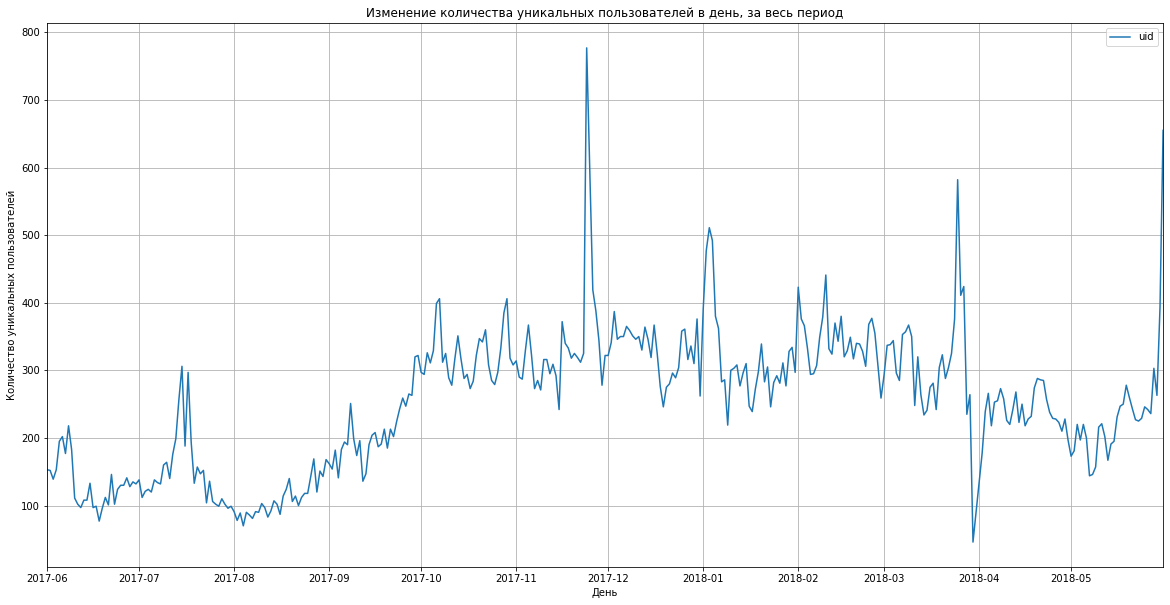

In [23]:
#Пользователи, которые заходили на сервис с телефона
plot_dau(visits_touch)

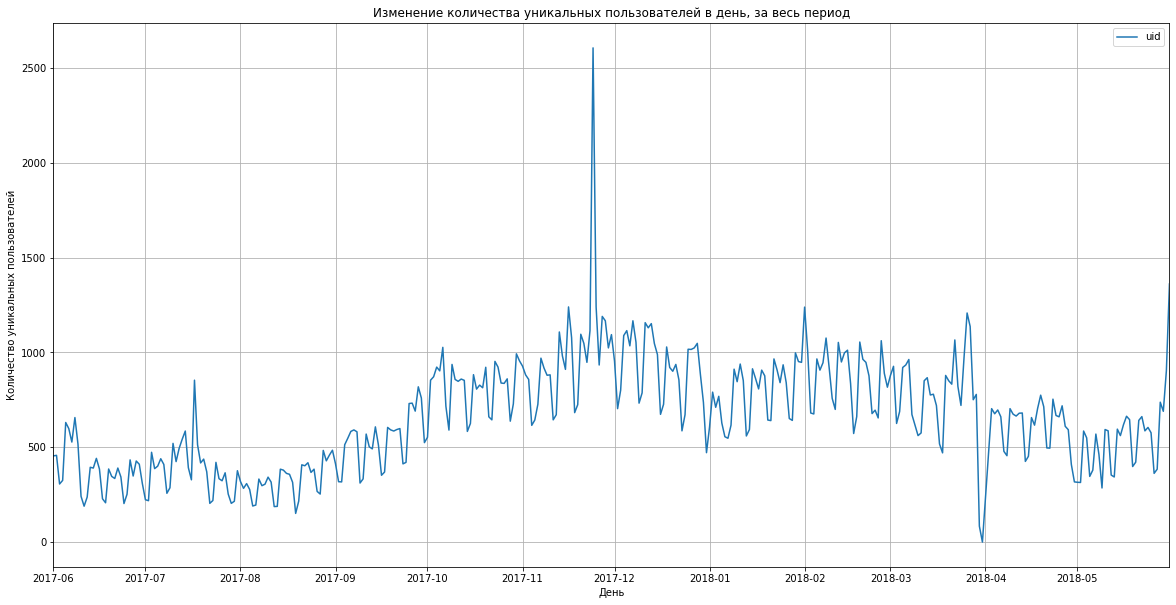

In [24]:
#Пользователи, которые заходили на сервис с компьютера
plot_dau(visits_desktop)

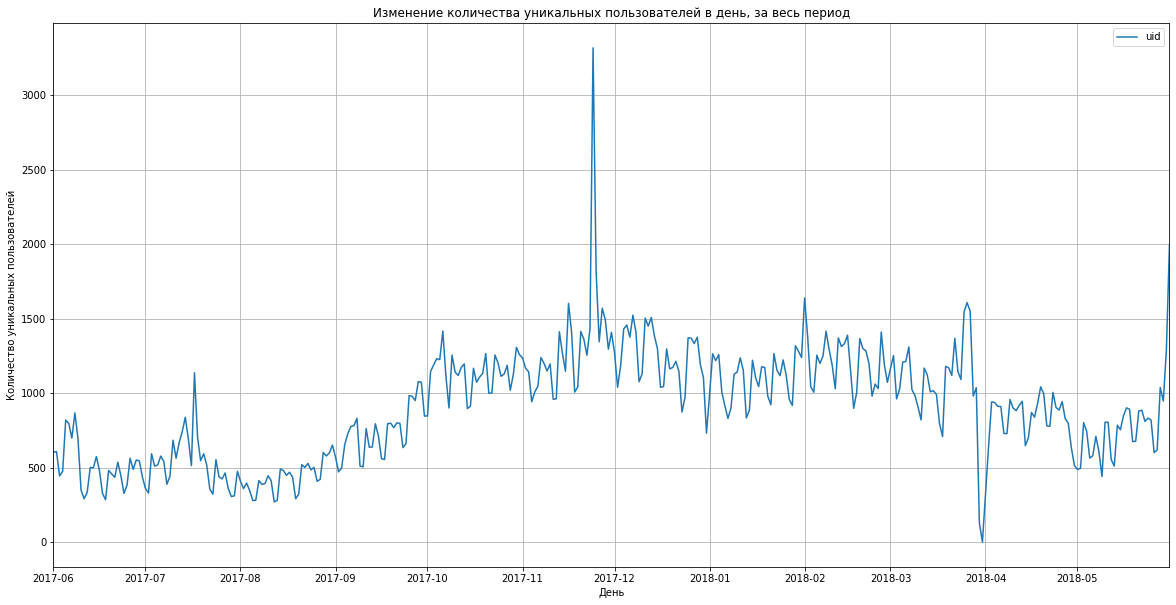

In [25]:
plot_dau(visits)

In [26]:
v1 = visits.groupby('start_ts_day').agg({'uid':'nunique'}).reset_index()
#v1.min()
v1.query('uid == 1')

,start_ts_day,uid
303,2018-03-31,1


В среднем, в день, на сервис, с компьютера заходит в 2.5 раза больше людей чем с телефона. Из графика "plot(visits_desktop)" видно что на сервис заходят в основном в будние дни, в выходные посетителей меньше. По всем графикам пиковое значение посетителей в день находится в конце ноября. В конце марта произошел провал по посещаемости.

* WAU - количество уникальных пользователей в неделю

In [27]:
def wau(df):
    wau_total = df.groupby(['start_ts_year', 'start_ts_week']).agg({'uid': 'nunique'}).mean()
    wau_total = np.ceil(wau_total)
    print('В среднем, за неделю , сервисом пользуются {} людей'.format(int(wau_total)))

In [28]:
#Пользователи, которые заходили на сервис с телефона
wau_touch = wau(visits_touch)
wau_touch

В среднем, за неделю , сервисом пользуются 1608 людей


In [29]:
#Пользователи, которые заходили на сервис с компьютера
wau_desktop = wau(visits_desktop)
wau_desktop

В среднем, за неделю , сервисом пользуются 4062 людей


In [30]:
#Общие визиты
wau_total = wau(visits)
wau_total

В среднем, за неделю , сервисом пользуются 5622 людей


In [31]:
def plot_wau(df):
    wau = (df.groupby(['start_ts_year', 'start_ts_week'])
                 .agg({'uid':'nunique'})
                 .reset_index()
           )
    x = ([str(x).replace(' 00:00:00', '') 
        for x in wau['start_ts_week']])
    y = wau['uid'].to_list()
    plt.figure(figsize=(16,9))
    plt.plot(x, y, marker='o')
    plt.title('Изменение количества уникальных пользователей в неделю, за весь период')
    plt.grid()
    plt.xlabel('Год, Неделя')
    plt.ylabel('Количество уникальных пользователей')
    plt.xticks(rotation=90)
    plt.show()

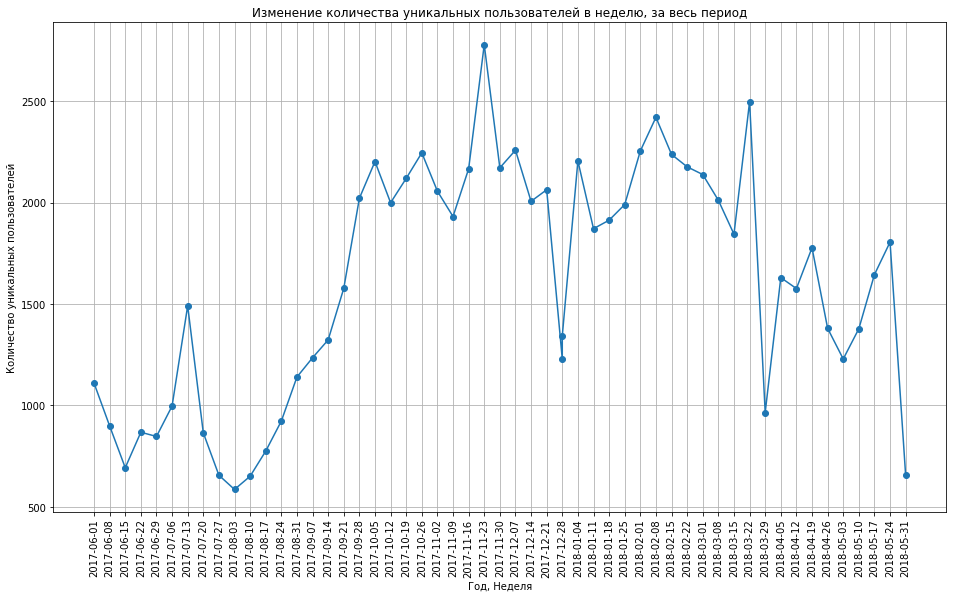

In [32]:
#Пользователи, которые заходили на сервис с телефона
plot_wau(visits_touch)

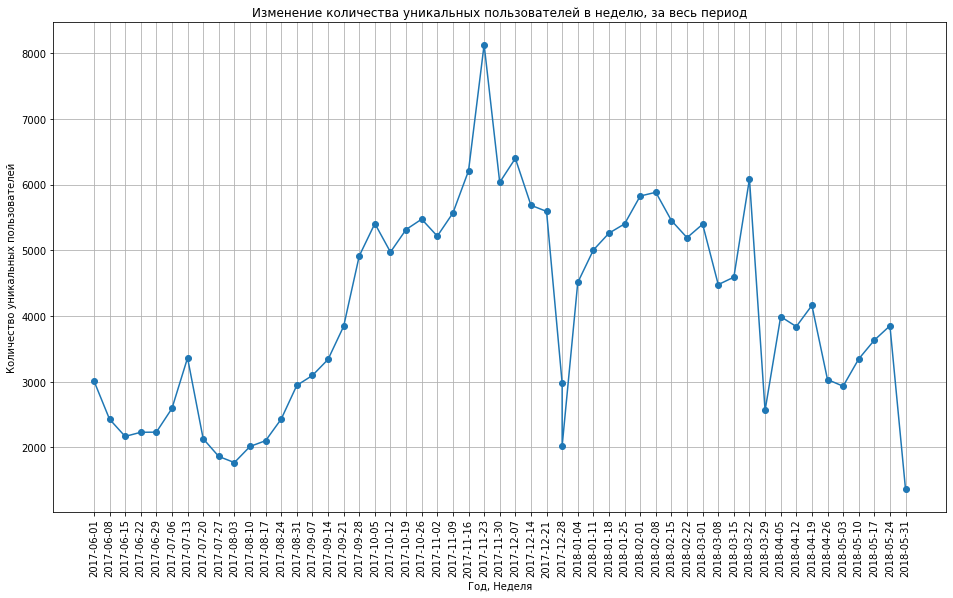

In [33]:
#Пользователи, которые заходили на сервис с компьютера
plot_wau(visits_desktop)

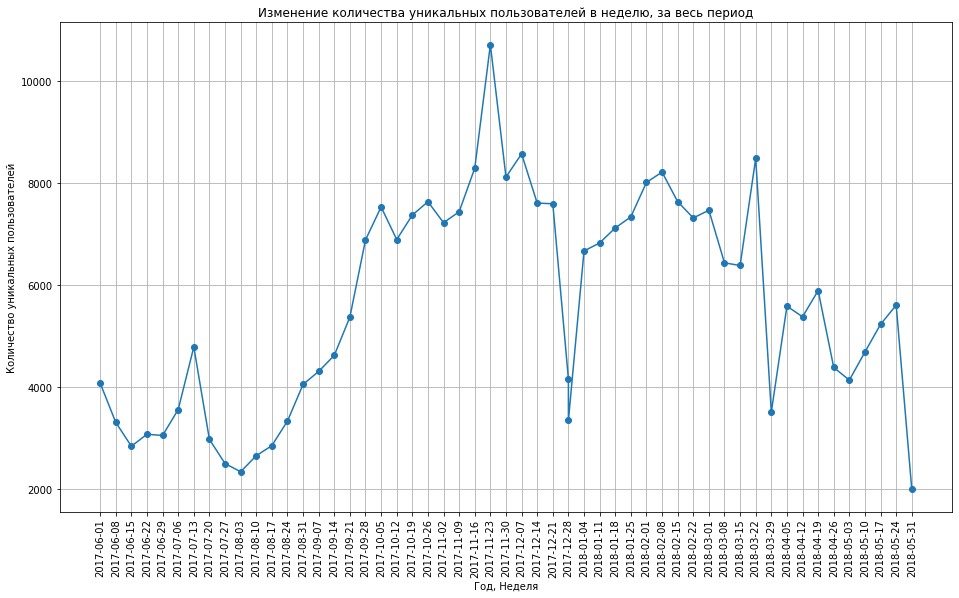

In [34]:
plot_wau(visits)

В среднем, в неделю, на сервис, с компьютера заходит в 2.5 раза больше людей чем с телефона. Схожие графики с DAU. Пик в конце ноября, провал в конце марта. Но есть еще одни провал по посещаемости - переходный период (декабрь - январь). Новогодние праздники дают о себе знать.

* MAU - количество уникальных пользователей в месяц

In [35]:
def mau(df):
    mau_total = df.groupby(['start_ts_year', 'start_ts_month']).agg({'uid': 'nunique'}).mean()
    mau_total = np.ceil(mau_total)
    print('В среднем, в месяц, сервисом пользуются {} людей'.format(int(mau_total)))

In [36]:
#Пользователи, которые заходили на сервис с телефона
mau_touch = mau(visits_touch)
mau_touch

В среднем, в месяц, сервисом пользуются 6826 людей


In [37]:
#Пользователи, которые заходили на сервис с компьютера
mau_desktop = mau(visits_desktop)
mau_desktop

В среднем, в месяц, сервисом пользуются 16725 людей


In [38]:
#Общие визиты
mau_total = mau(visits)
mau_total

В среднем, в месяц, сервисом пользуются 23229 людей


In [39]:
def plot_mau(df):
    mau = (df.groupby(['start_ts_year', 'start_ts_month'])
                 .agg({'uid':'nunique'})
                 .reset_index()
           )
    x = ([str(x).replace(' 00:00:00', '') 
        for x in mau['start_ts_month']])
    y = mau['uid'].to_list()
    plt.figure(figsize=(16,9))
    plt.bar(x, y)
    plt.title('Изменение количества уникальных пользователей в месяц, за весь период')
    plt.grid()
    plt.xlabel('Год, Месяц')
    plt.ylabel('Количество уникальных пользователей')
    plt.show()

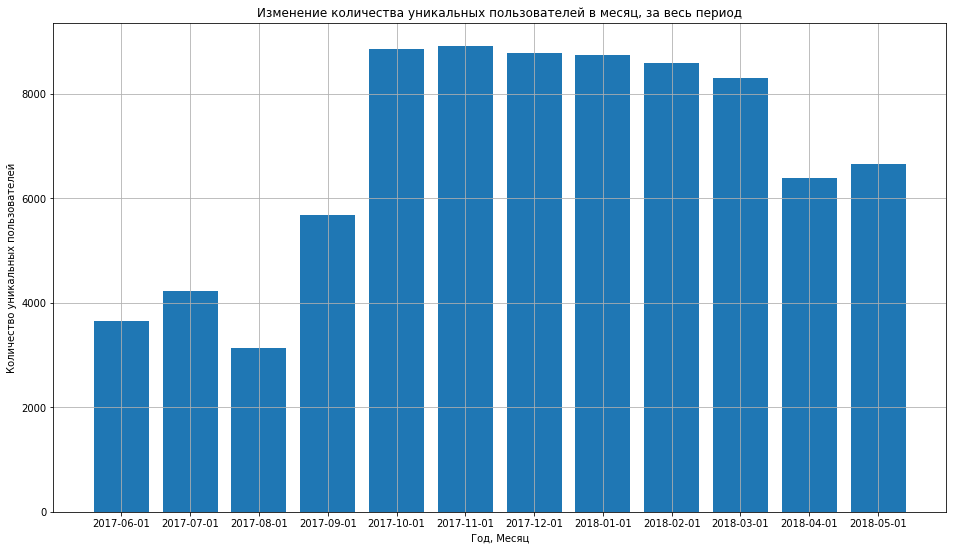

In [40]:
#Пользователи, которые заходили на сервис с телефона
plot_mau(visits_touch)

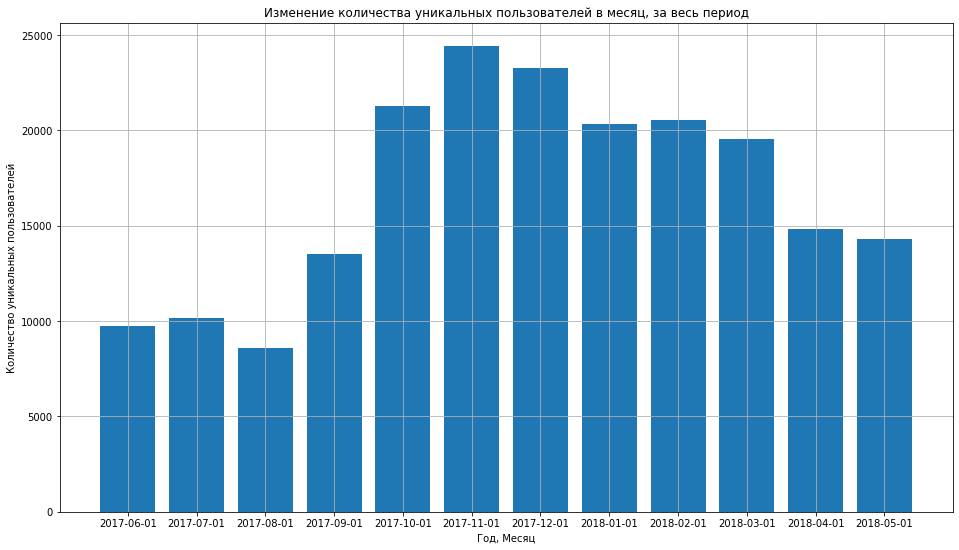

In [41]:
#Пользователи, которые заходили на сервис с компьютера
plot_mau(visits_desktop)

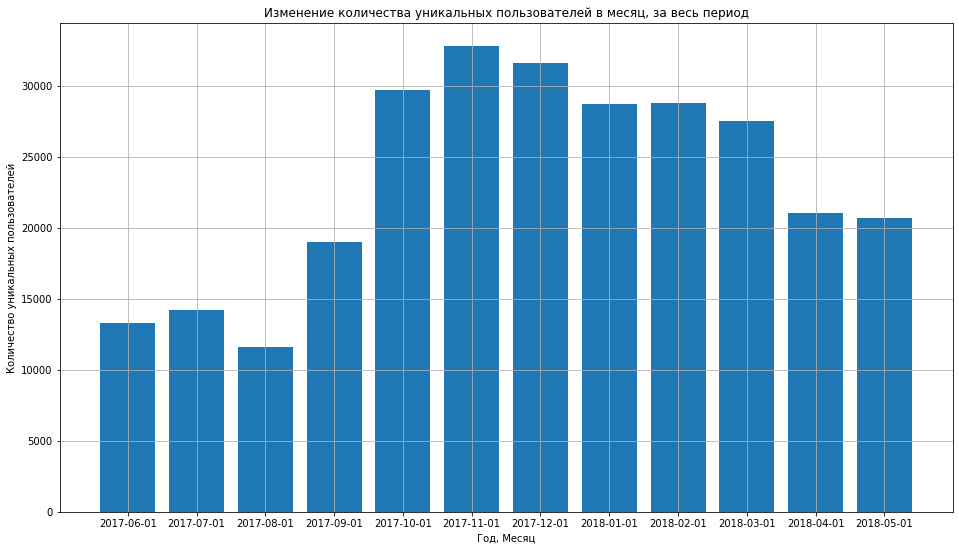

In [42]:
plot_mau(visits)

В среднем, в месяц, на сервис, с компьютера заходит в 2.5 раза больше людей чем с телефона. 

В целом по месяцам все просто. Пик в ноябре - декабре (октябрь-март у visits_touch). Скорее всего подкатовка к Н.Г. Потом снижение.


>**<span style="color:green">По расчёту этих метрик у тебя все хорошо, отдельно похвалю тебя за уверенную и качественную работу с визуализациями. Хорошо, что посчитал данные метрики в разрезе типов устройств. Так держать! :)</span>**
>


#### 2.1.2. Определим, сколько раз за день пользователи в среднем заходят на сайт. Выясним, как изменяется эта метрика с течением времени

In [43]:
#Пользователи, которые заходили на сервис с телефона
daily_visits_touch = visits_touch.groupby('start_ts_day').agg({'uid':'count'}).mean()
daily_visits_touch = np.ceil(daily_visits_touch)
print('В среднем, в день, на сервис, с телефона, заходят {} раз'.format(int(daily_visits_touch)))

В среднем, в день, на сервис, с телефона, заходят 267 раз


In [44]:
#Пользователи, которые заходили на сервис с компьютера
daily_visits_desktop = visits_desktop.groupby('start_ts_day').agg({'uid':'count'}).mean()
daily_visits_desktop = np.ceil(daily_visits_desktop)
print('В среднем, в день, на сервис, с компьютера, заходят {} раз'.format(int(daily_visits_desktop)))

В среднем, в день, на сервис, с компьютера, заходят 722 раз


In [45]:
#Общие визиты
daily_total = visits.groupby('start_ts_day').agg({'uid':'count'}).mean()
daily_total = np.ceil(daily_total)
print('В среднем, в день, на сервис заходят {} раз'.format(int(daily_total)))

В среднем, в день, на сервис заходят 988 раз


In [46]:
visit_per_day_touch = daily_visits_touch / dau_touch
print('В среднем, в день, один человек заходит на сервис c телефона {:.2f} раз'.format(float(visit_per_day_touch)))

В среднем, в день, один человек заходит на сервис c телефона 1.06 раз


In [47]:
visit_per_day_desktop = daily_visits_desktop/dau_desktop
print('В среднем, в день, один человек заходит на сервис c компьютера {:.2f} раз'.format(float(visit_per_day_desktop)))

В среднем, в день, один человек заходит на сервис c компьютера 1.09 раз


In [48]:
visit_per_day = daily_total/dau_total
print('В среднем, в день, один человек заходит на сервис {:.2f} раз'.format(float(visit_per_day)))

В среднем, в день, один человек заходит на сервис 1.09 раз


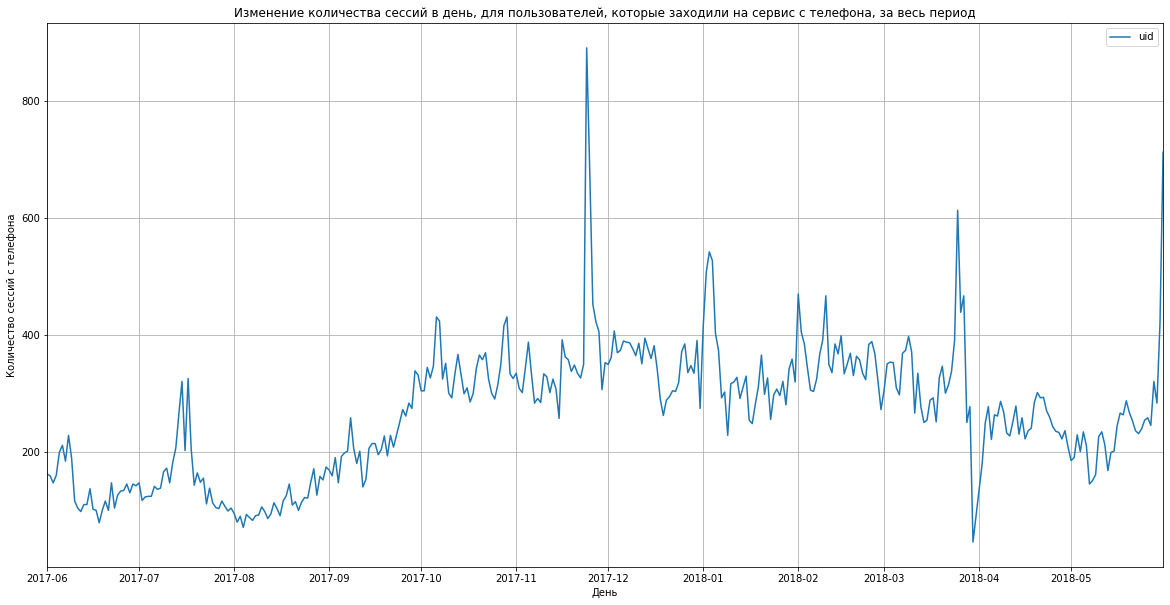

In [49]:
(visits_touch.groupby('start_ts_day')
       .agg({'uid':'count'})
       .plot(title=
             ('Изменение количества сессий в день, для пользователей, которые заходили на сервис с телефона, за весь период'),
             figsize=(20,10), grid=True)
)
plt.xlabel('День')
plt.ylabel('Количество сессий c телефона')
plt.show()

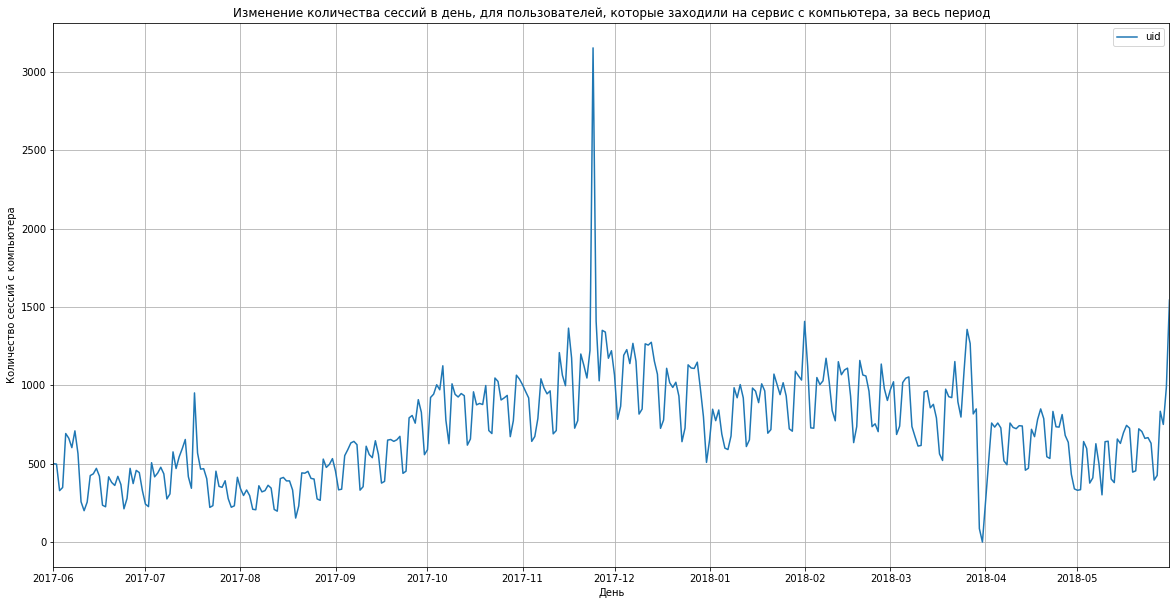

In [50]:
(visits_desktop.groupby('start_ts_day')
       .agg({'uid':'count'})
       .plot(title=
             ('Изменение количества сессий в день, для пользователей, которые заходили на сервис с компьютера, за весь период'),
             figsize=(20,10), grid=True)
)
plt.xlabel('День')
plt.ylabel('Количество сессий с компьютера')
plt.show()

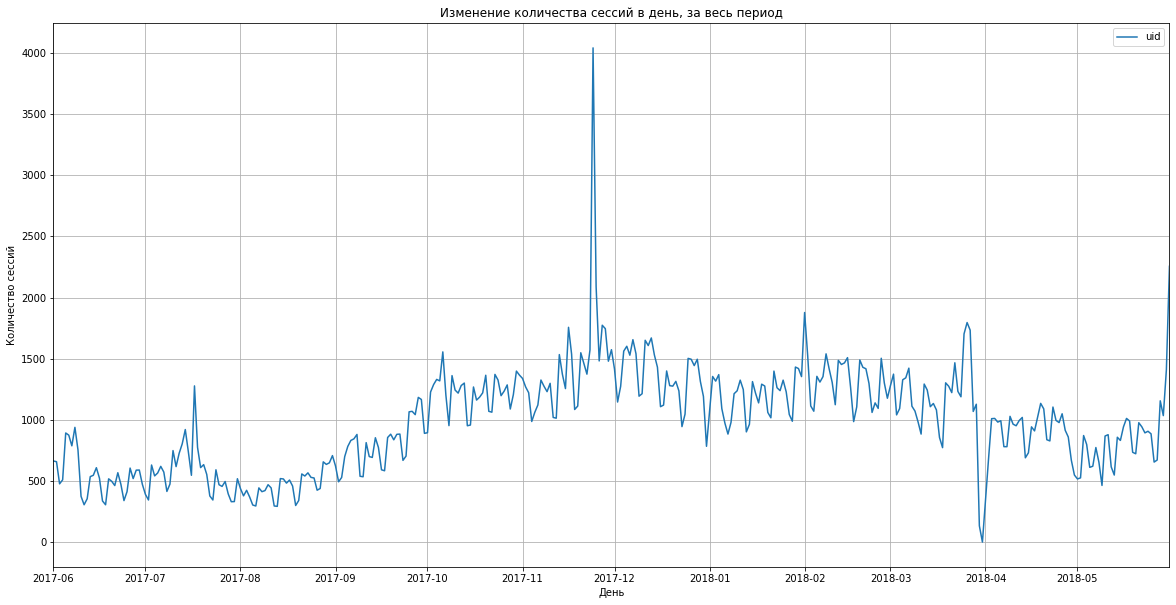

In [51]:
(visits.groupby('start_ts_day')
       .agg({'uid':'count'})
       .plot(title=('Изменение количества сессий в день, за весь период'), figsize=(20,10), grid=True)
)
plt.xlabel('День')
plt.ylabel('Количество сессий')
plt.show()

По выходным посетителей меньше чем в будние дни. Пиковое значение посетителей в день находится в конце ноября. В конце марта произошел провал по посещаемости.


>**<span style="color:green">Здесь все окей.</span>**
>


#### 2.1.3. Сколько длится одна сессия?

Cколько времени пользователи проводят на сайте. Посчитаем среднюю продолжительность пользовательской сессии за весь период. Выясним, как продолжительность сессий распределена по пользователям

In [52]:
print('Средняя продолжительность сессии (ASL) {:.2f} секунды'.format(visits['duration'].mean()))

Средняя продолжительность сессии (ASL) 643.51 секунды


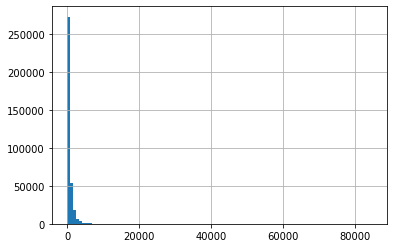

In [53]:
#Гистограмма продолжительности сессий
visits['duration'].hist(bins=100)

Не очень информотивно. Возле 0 много значений.

In [54]:
#Напишем фукцию для ящика с усами
def boxplot(df):
    plt.figure(figsize=(20,10))
    ax = sns.boxplot(y="duration", data=df, orient="h")
    #ax.set_xlim([0, 1000])
    ax.set_title('boxplot по времени одной сессии')
    plt.show()

In [55]:
#Построим ящик с усами для пользователей, которые заходили на сервис с телевона

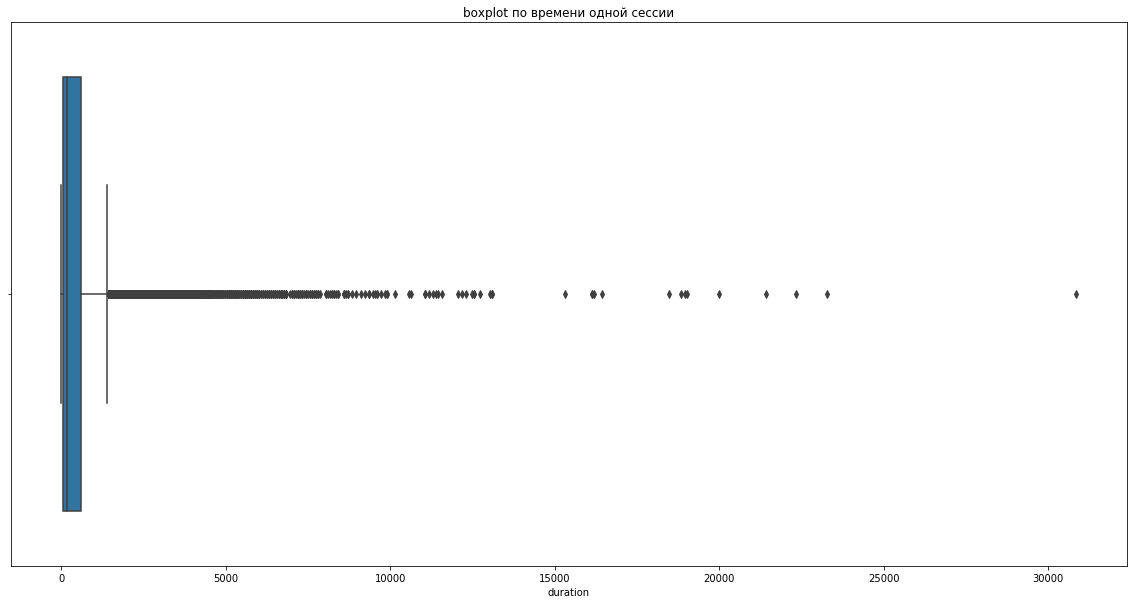

In [56]:
boxplot(visits_touch)

In [57]:
visits_touch.describe().T

,count,mean,std,min,25%,50%,75%,max
index,96833.0,1.796113e+05,1.037244e+05,0.000000e+00,8.961400e+04,1.795100e+05,2.694850e+05,3.593990e+05
source_id,96833.0,3.795287e+00,1.843730e+00,1.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,1.000000e+01
uid,96833.0,9.201074e+18,5.323867e+18,1.186350e+13,4.598311e+18,9.242037e+18,1.379593e+19,1.844656e+19
duration,96833.0,4.796194e+02,7.525315e+02,0.000000e+00,6.000000e+01,1.800000e+02,6.000000e+02,3.084000e+04
start_ts_year,96833.0,2.017468e+03,4.989803e-01,2.017000e+03,2.017000e+03,2.017000e+03,2.018000e+03,2.018000e+03


Есть 0-вые значения во времени одной сессии. Человек не смог открыть сайт. Есть вбросы после 600 сеунд (10 мин)

In [58]:
#Построим ящик с усами для пользователей, которые заходили на сервис с компьютера

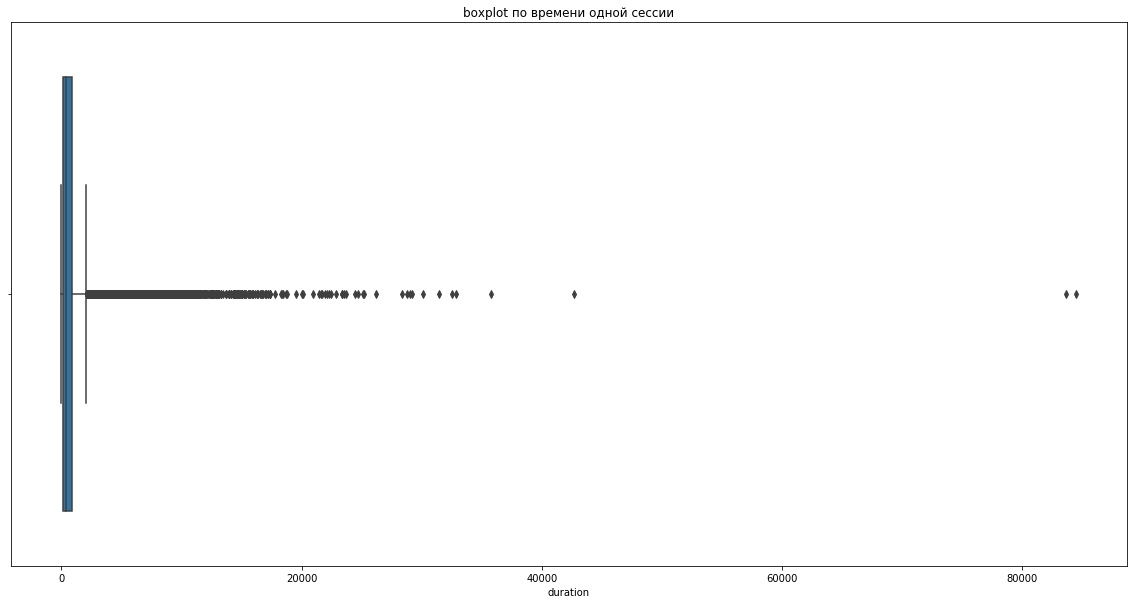

In [59]:
boxplot(visits_desktop)

In [60]:
visits_desktop.describe().T

,count,mean,std,min,25%,50%,75%,max
index,262567.0,1.797320e+05,1.037596e+05,1.000000e+00,8.993950e+04,1.797780e+05,2.695665e+05,3.593980e+05
source_id,262567.0,3.734003e+00,1.943224e+00,1.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,1.000000e+01
uid,262567.0,9.203104e+18,5.289032e+18,2.977294e+14,4.618006e+18,9.221708e+18,1.370360e+19,1.844668e+19
duration,262567.0,7.039470e+02,1.091546e+03,0.000000e+00,1.200000e+02,3.600000e+02,9.000000e+02,8.448000e+04
start_ts_year,262567.0,2.017448e+03,4.972888e-01,2.017000e+03,2.017000e+03,2.017000e+03,2.018000e+03,2.018000e+03


Есть 0-вые значения во времени одной сессии. Человек не смог открыть сайт. Есть вбросы после 900 сеунд (15 мин)

In [61]:
#Построим ящик с усами для общего кол-ва пользователей

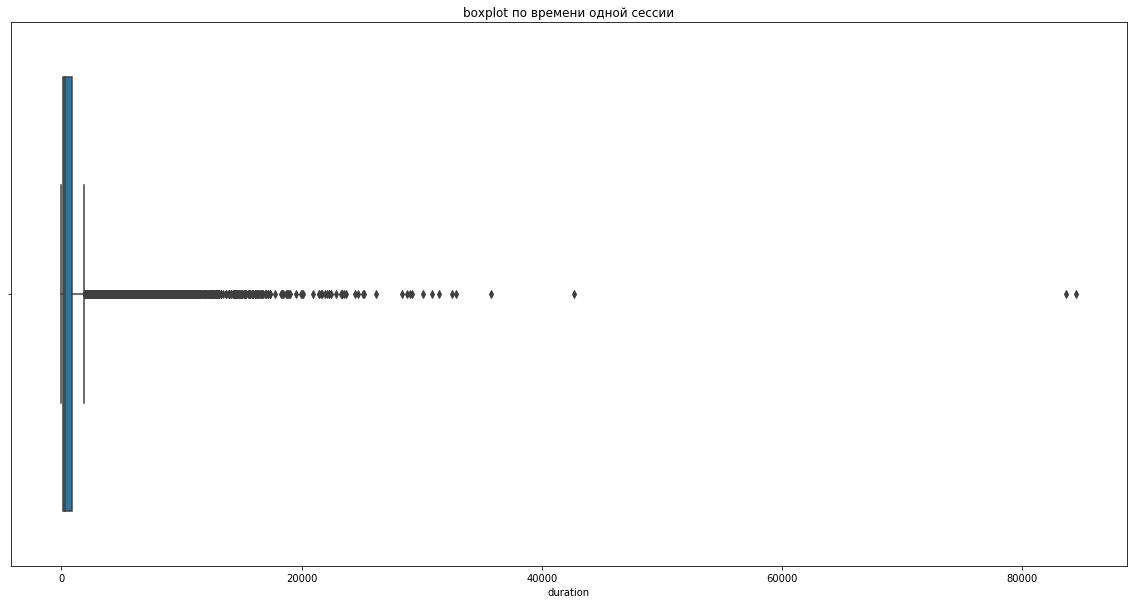

In [62]:
boxplot(visits)

In [63]:
visits.describe().T

,count,mean,std,min,25%,50%,75%,max
source_id,359400.0,3.750515e+00,1.917116e+00,1.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,1.000000e+01
uid,359400.0,9.202557e+18,5.298433e+18,1.186350e+13,4.613407e+18,9.227413e+18,1.372824e+19,1.844668e+19
duration,359400.0,6.435065e+02,1.016335e+03,0.000000e+00,1.200000e+02,3.000000e+02,8.400000e+02,8.448000e+04
start_ts_year,359400.0,2.017453e+03,4.978239e-01,2.017000e+03,2.017000e+03,2.017000e+03,2.018000e+03,2.018000e+03


Есть 0-вые значения во времени одной сессии. Человек не смог открыть сайт. Есть вбросы после 840 сеунд (14 мин)

У Пользователей, которые заходили на сервис с телевона: Посмотрим сколько сессий до 60 сек. и после 600 сек

In [64]:
print('Пользователи, которые заходили на сервис с телевона:\
{} Сессий продолжительностью до 60 секунд'.format(visits_touch.query('duration < 60')['duration'].count()))

Пользователи, которые заходили на сервис с телевона:12319 Сессий продолжительностью до 60 секунд


In [65]:
print('Пользователи, которые заходили на сервис с телевона:\
{} Сессий продолжительностью свыше 600 секунд'.format(visits_touch.query('duration > 600')['duration'].count()))

Пользователи, которые заходили на сервис с телевона:23414 Сессий продолжительностью свыше 600 секунд


У Пользователей, которые заходили на сервис с компьютера: Посмотрим сколько сессий до 120 сек. и после 900 сек

In [66]:
print('Пользователи, которые заходили на сервис с компьютера:\
{} Сессий продолжительностью до 120 секунд'.format(visits_desktop.query('duration < 120')['duration'].count()))

Пользователи, которые заходили на сервис с компьютера:59754 Сессий продолжительностью до 120 секунд


In [67]:
print('Пользователи, которые заходили на сервис с компьютера:\
{} Сессий продолжительностью свыше 900 секунд'.format(visits_desktop.query('duration > 900')['duration'].count()))

Пользователи, которые заходили на сервис с компьютера:64696 Сессий продолжительностью свыше 900 секунд


In [68]:
print('Все пользователи:\
{} Сессий продолжительностью до 120 секунд'.format(visits.query('duration < 120')['duration'].count()))

Все пользователи:89691 Сессий продолжительностью до 120 секунд


In [69]:
print('Все пользователи:\
{} Сессий продолжительностью свыше 840 секунд'.format(visits.query('duration > 840')['duration'].count()))

Все пользователи:86015 Сессий продолжительностью свыше 840 секунд


Посторим гистограммы без нулевых значений и меньше 30 мин. (1800 сек.)

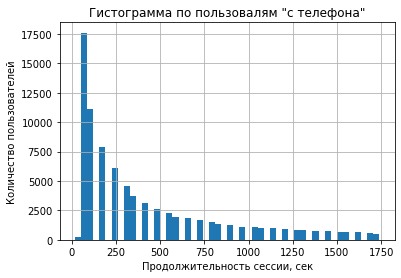

In [70]:
visits_touch.query('duration > 0 & duration < 1800')['duration'].hist(bins=50)
plt.title('Гистограмма по пользовалям "с телефона"')
plt.xlabel('Продолжительность сессии, сек')
plt.ylabel('Количество пользователей')
plt.show()

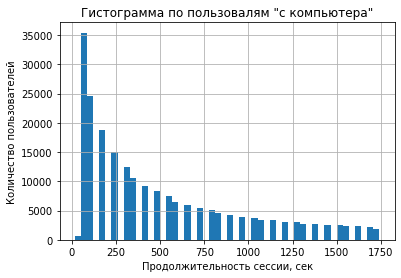

In [71]:
visits_desktop.query('duration > 0 & duration < 1800')['duration'].hist(bins=50)
plt.title('Гистограмма по пользовалям "с компьютера"')
plt.xlabel('Продолжительность сессии, сек')
plt.ylabel('Количество пользователей')
plt.show()

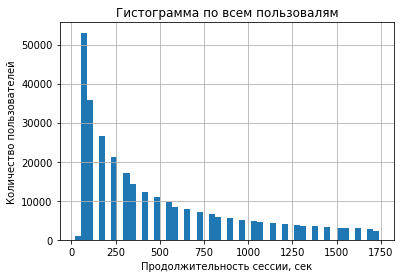

In [72]:
visits.query('duration > 0 & duration < 1800')['duration'].hist(bins=50)
plt.title('Гистограмма по всем пользовалям')
plt.xlabel('Продолжительность сессии, сек')
plt.ylabel('Количество пользователей')
plt.show()

In [73]:
print('Средняя продолжительность сессии (ASL), пользователей, которые заходили на сервис с телевона - {} секунд'\
      .format(int(visits_touch['duration'].mode())))

Средняя продолжительность сессии (ASL), пользователей, которые заходили на сервис с телевона - 60 секунд


In [74]:
print('Средняя продолжительность сессии (ASL), пользователей, которые заходили на сервис с компьютера - {} секунд'\
      .format(int(visits_desktop['duration'].mode())))

Средняя продолжительность сессии (ASL), пользователей, которые заходили на сервис с компьютера - 60 секунд


In [75]:
print('Средняя продолжительность сессии (ASL) всех пользователей {} секунд'.format(int(visits['duration'].mode())))

Средняя продолжительность сессии (ASL) всех пользователей 60 секунд


#### 2.1.4. Рассчитаем Retention Rate, применяя когортный анализ.

In [76]:
first_visit_date = visits.groupby('uid')['start_ts'].min()
first_visit_date.name = 'first_visit'
visits = visits.join(first_visit_date, on='uid')

visits['first_visits_month'] = visits['first_visit'].astype('datetime64[M]')

visits['cohort_lifetime'] = visits['start_ts_month'] - visits['first_visits_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].apply(np.round).astype('int')
visits.head()

,device,end_ts,source_id,start_ts,uid,duration,start_ts_year,start_ts_month,start_ts_week,start_ts_day,first_visit,first_visits_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080,2017,2017-12-01,2017-12-14,2017-12-20,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680,2018,2018-02-01,2018-02-15,2018-02-19,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017,2017-07-01,2017-06-29,2017-07-01,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440,2018,2018-05-01,2018-05-17,2018-05-20,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0,2017,2017-12-01,2017-12-21,2017-12-27,2017-12-27 14:06:00,2017-12-01,0


In [77]:
#Поделим таблицу visits по столбцу device
visits_touch = visits[visits['device'] == 'touch'].reset_index()
visits_desktop = visits[visits['device'] == 'desktop'].reset_index()

In [78]:
#Напишем функцию для Retention Rate
title_list = ('Retention Rate, для пользователей, которые заходили на сервис с телевона',\
              'Retention Rate, для пользователей, которые заходили на сервис с компьютера',\
              'Retention Rate, для всех пользователей')
def rr(df):
    cohorts = df.groupby(['first_visits_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
    #Начальное кол-во пользователей
    initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visits_month','uid']]
    initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
    #Добавим коэф. удержания
    cohorts = cohorts.merge(initial_users_count,on='first_visits_month')
    cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']
    
    retention_pivot = cohorts.pivot_table(index='first_visits_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
    
    retention_pivot.index = retention_pivot.index.strftime('%Y-%m-%d')
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    #plt.title('Когорты: Удержание пользователей')
    sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='white', cmap = 'RdYlGn', vmax = 0.1)
    plt.ylabel('Месяц первой активности')
    plt.xlabel('Прошло месяцев с первой активности')
    #plt.show()

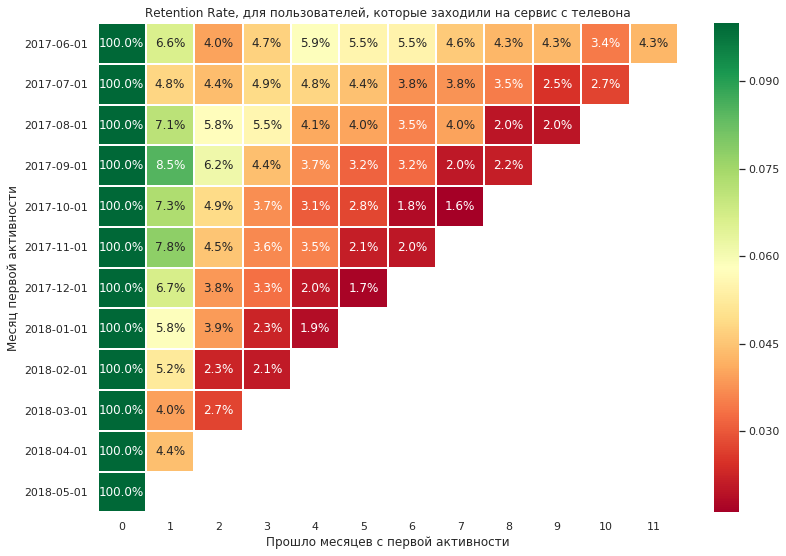

In [79]:
rr(visits_touch)
plt.title('Retention Rate, для пользователей, которые заходили на сервис с телевона')
plt.show()

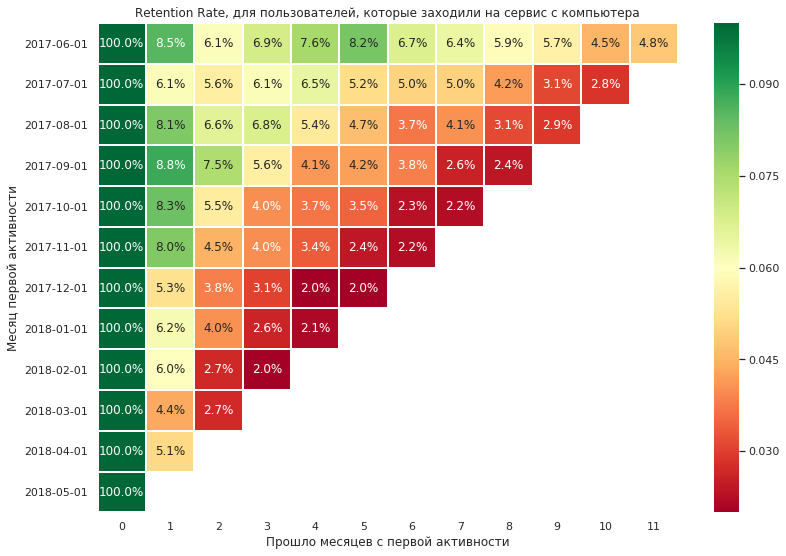

In [80]:
rr(visits_desktop)
plt.title('Retention Rate, для пользователей, которые заходили на сервис с компьютера')
plt.show()

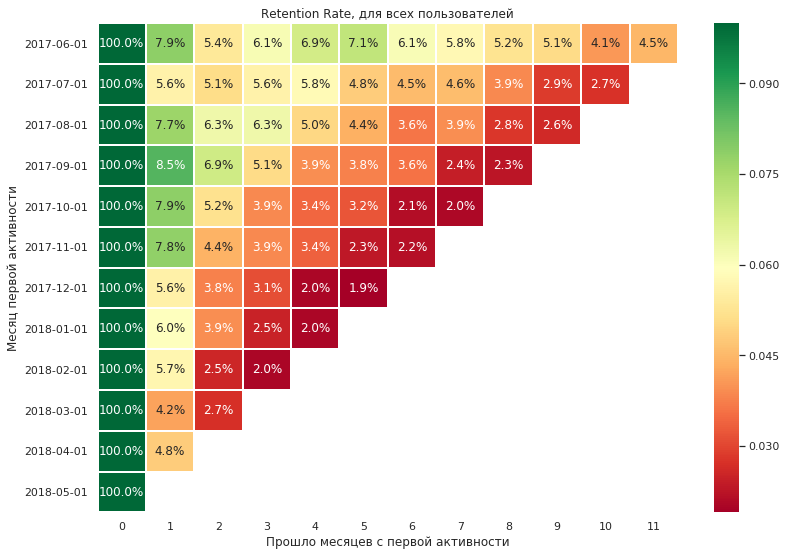

In [81]:
rr(visits)
plt.title('Retention Rate, для всех пользователей')
plt.show()

Необходимо отметить, что **Retention** довольно низкий. **Retention** второго месяца пользования сервисом находится в интервале от 5 до 8,5% в зависимости от когорты. Причем после одного месяца пользования, на второй, возвращается большая часть клиентов, далее, с течением времени, этот процент падает до 2-2,7%.
Это справедливо для всех, кроме самой первой когорты, которая начала пользоваться ресурсом в июне 2017 года. Их Retention тоже довольно низкий, но постоянно находится в "лидерах" по сравнении со всеми остальными когортами.

### 2.2. Метрики электронной коммерции
#### 2.2.1. Исследуйте, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки

Когда люди начинают покупать?

In [82]:
#Найдем время и дату первой сессии
first_sessions = visits.groupby(['uid']).agg({'start_ts':'min', 'source_id':'first', 'device':'first'})
first_sessions.columns = ['first_activity', 'first_source_id', 'first_device']
first_sessions

,first_activity,first_source_id,first_device
uid,,,
11863502262781,2018-03-01 17:27:00,3,touch
49537067089222,2018-02-06 15:55:00,2,touch
297729379853735,2017-06-07 18:47:00,3,desktop
313578113262317,2017-09-18 22:49:00,2,desktop
325320750514679,2017-09-30 14:29:00,5,desktop
...,...,...,...
18446403737806311543,2017-11-30 03:36:00,5,desktop
18446424184725333426,2017-12-06 20:32:00,4,touch
18446556406699109058,2018-01-01 16:29:00,3,touch


In [83]:
#найдем время первой покупки
first_orders = orders.groupby(['uid']).agg({'buy_ts':'min'})
first_orders.columns = ['first_buy_ts']

#добавим дату и время первой сессии в информацию по первым заказам
first_orders = first_orders.join(first_sessions,on='uid')

In [84]:
#найдем время, прошедшее с момента первой сессии до первой покупки
first_orders['time_to_first_purchase'] = ((first_orders['first_buy_ts'] - first_orders['first_activity'])
                                          / np.timedelta64(1, 'm')
                                         )
first_orders

,first_buy_ts,first_activity,first_source_id,first_device,time_to_first_purchase
uid,,,,,
313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,2,desktop,154022.0
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,10,touch,0.0
2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,3,desktop,79.0
2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,5,desktop,1184.0
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,5,desktop,0.0
...,...,...,...,...,...
18445147675727495770,2017-11-24 09:03:00,2017-08-20 13:30:00,5,touch,137973.0
18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00,3,desktop,7.0
18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00,2,desktop,333303.0


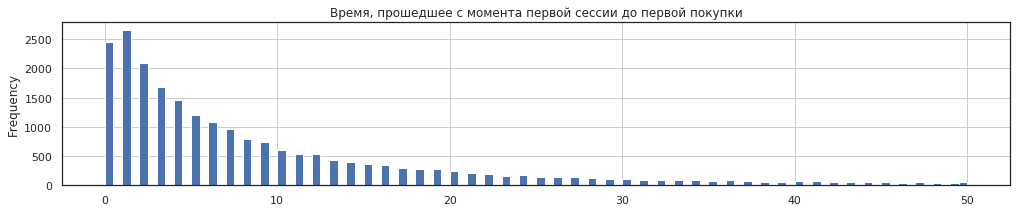

In [85]:
#Посторим Гистограмму распределения разницы между временем первого заказа и началом первой сессии
first_orders['time_to_first_purchase'].plot(kind = 'hist', bins = 100, range = (0,50), figsize = (17,3), grid=True, 
                                            title = 'Время, прошедшее с момента первой сессии до первой покупки')
plt.show()

In [86]:
print('Медиана времени с первой сессии до первой покупки: {} минут'.format(int(first_orders['time_to_first_purchase'].
                                                                               median())))
print('Среднее время с певрой сессии до первой покупки: {} дней'.format(int(first_orders['time_to_first_purchase'].
                                                                            mean()/60/24)))
print('Мода времени с певрой сессии до первой покупки: {} минута'.format(int(first_orders['time_to_first_purchase'].mode())))

Медиана времени с первой сессии до первой покупки: 16 минут
Среднее время с певрой сессии до первой покупки: 16 дней
Мода времени с певрой сессии до первой покупки: 1 минута


У большей части пользователей на оформление заказа уходит не более 3-5 минут. Т.е. они заходят на сервис и сразу делают заказ. Видно, что заходят они сразу по делу, а не посидеть поискать что-либо интересное.

#### 2.2.2. Применяя когортный анализ, рассчитайте среднее количество покупок на одного клиента за определённый период, например за 6 месяцев
Сколько раз покупают за период?

In [87]:
orders

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


In [88]:
#добавим в orders дату первого заказа и выведем в отдельный столбец месяц первого заказа
orders = orders.join(first_orders, on='uid')
orders['first_order_month'] = orders['first_buy_ts'].astype('datetime64[M]')
orders['month'] = orders['buy_ts'].astype('datetime64[M]')

In [89]:
orders

,buy_ts,revenue,uid,first_buy_ts,first_activity,first_source_id,first_device,time_to_first_purchase,first_order_month,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,1,desktop,1.0,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,2,desktop,11.0,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,2,desktop,2.0,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,2,desktop,15.0,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,3,desktop,27.0,2017-06-01,2017-06-01
...,...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-31 09:11:00,4,desktop,879.0,2018-05-01,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-31 23:05:00,10,desktop,45.0,2018-05-01,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-31 23:52:00,3,desktop,2.0,2018-05-01,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2017-10-23 12:32:00,4,desktop,317484.0,2018-05-01,2018-05-01


In [90]:
#количество первых покупателей для каждого месяца 
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [91]:
cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [92]:
#Выделим когорты
cohort_grouped_orders = orders.groupby(['first_order_month', 'month']).agg({'revenue':'count', 'uid':'nunique'}).reset_index()
cohort_grouped_orders

,first_order_month,month,revenue,uid
0,2017-06-01,2017-06-01,2354,2023
1,2017-06-01,2017-07-01,177,61
2,2017-06-01,2017-08-01,174,50
3,2017-06-01,2017-09-01,226,54
4,2017-06-01,2017-10-01,292,88
...,...,...,...,...
74,2018-03-01,2018-05-01,176,58
75,2018-04-01,2018-04-01,2495,2276
76,2018-04-01,2018-05-01,195,69
77,2018-05-01,2018-05-01,3249,2988


In [93]:
#данные по посетителям и когортам 
cohort_grouped_orders = pd.merge(cohort_grouped_orders, cohort_sizes, on='first_order_month')
cohort_grouped_orders

,first_order_month,month,revenue,uid,n_buyers
0,2017-06-01,2017-06-01,2354,2023,2023
1,2017-06-01,2017-07-01,177,61,2023
2,2017-06-01,2017-08-01,174,50,2023
3,2017-06-01,2017-09-01,226,54,2023
4,2017-06-01,2017-10-01,292,88,2023
...,...,...,...,...,...
74,2018-03-01,2018-05-01,176,58,3533
75,2018-04-01,2018-04-01,2495,2276,2276
76,2018-04-01,2018-05-01,195,69,2276
77,2018-05-01,2018-05-01,3249,2988,2988


In [94]:
#Добавим среднее кол-во покупок для одного клиента
cohort_grouped_orders['mean_purchase_per_user'] = cohort_grouped_orders['revenue'] / cohort_grouped_orders['n_buyers']

In [95]:
cohort_grouped_orders

,first_order_month,month,revenue,uid,n_buyers,mean_purchase_per_user
0,2017-06-01,2017-06-01,2354,2023,2023,1.163618
1,2017-06-01,2017-07-01,177,61,2023,0.087494
2,2017-06-01,2017-08-01,174,50,2023,0.086011
3,2017-06-01,2017-09-01,226,54,2023,0.111715
4,2017-06-01,2017-10-01,292,88,2023,0.144340
...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,176,58,3533,0.049816
75,2018-04-01,2018-04-01,2495,2276,2276,1.096221
76,2018-04-01,2018-05-01,195,69,2276,0.085677
77,2018-05-01,2018-05-01,3249,2988,2988,1.087349


In [96]:
cohort_grouped_orders = cohort_grouped_orders.reset_index()
cohort_grouped_orders['cohort_lifetime'] = cohort_grouped_orders['month'] - cohort_grouped_orders['first_order_month']

cohort_grouped_orders['cohort_lifetime'] = ((cohort_grouped_orders['cohort_lifetime'] / np.timedelta64(1,'M'))
                                            .round().astype('int')
                                           )

cohort_grouped_orders['first_order_month'].dt.strftime('%d.%m.%Y')
cohort_grouped_orders['first_order_month'] = cohort_grouped_orders['first_order_month'].dt.strftime('%Y-%m')

revenue_per_user_pivot = (cohort_grouped_orders.pivot_table(index='first_order_month',columns='cohort_lifetime',
                                                            values='mean_purchase_per_user',aggfunc='mean')
                         )

In [97]:
#Среднее накопительное кол-во покупок одного пользователя
revenue_per_user_pivot = revenue_per_user_pivot.cumsum(axis=1).copy()
revenue_per_user_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,1.163618,1.251112,1.337123,1.448838,1.593178,1.700939,1.837370,1.923381,2.028176,2.103806,2.151261,2.193772
2017-07,1.136765,1.188768,1.251170,1.305252,1.342694,1.385335,1.417057,1.443058,1.473219,1.485699,1.513261,NaN
2017-08,1.118978,1.197810,1.270803,1.329927,1.391971,1.437226,1.472993,1.529927,1.563504,1.597080,NaN,NaN
2017-09,1.136381,1.221232,1.283611,1.347152,1.373111,1.415343,1.457187,1.478884,1.502518,NaN,NaN,NaN
2017-10,1.143779,1.216129,1.253456,1.281567,1.311290,1.335023,1.354839,1.383641,NaN,NaN,NaN,NaN
2017-11,1.179368,1.276648,1.321245,1.372948,1.406273,1.420730,1.445724,NaN,NaN,NaN,NaN,NaN
2017-12,1.152635,1.214237,1.260324,1.301164,1.320785,1.344741,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.121554,1.187963,1.235102,1.254076,1.277201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.121611,1.182416,1.205149,1.224322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


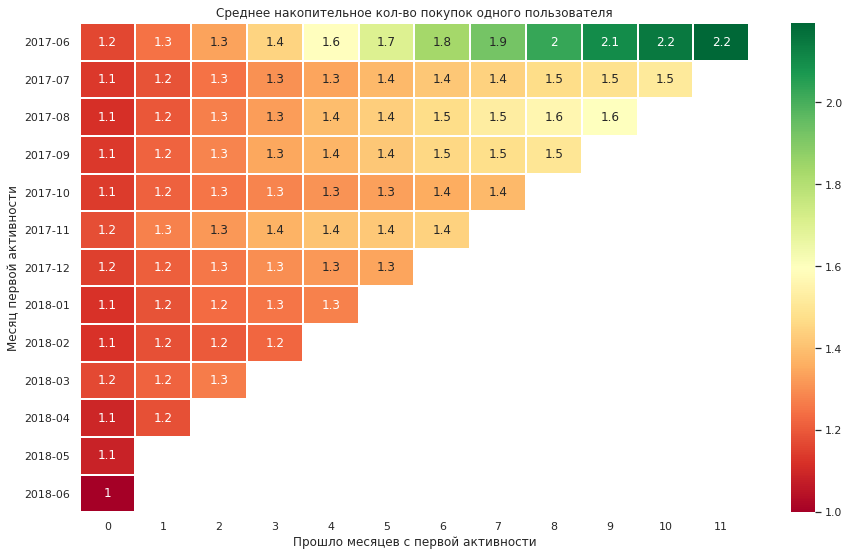

In [98]:
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Среднее накопительное кол-во покупок одного пользователя')
sns.heatmap(revenue_per_user_pivot, annot=True, linewidths=1, linecolor='white', cmap = 'RdYlGn')
plt.ylabel('Месяц первой активности')
plt.xlabel('Прошло месяцев с первой активности')
plt.show()

Первая когора снова ледирует. 

На 6ом месяце, во всех когортах, накопительное число покупок одного пользовалеля приближается к 1,5. Исключение Первая когорта.

**2.2.3. Рассчитайте среднюю выручку с пользователя. Покажите, как меняется эта метрика с течением времени**

Какой средний чек?

In [99]:
cohort_grouped_orders

,index,first_order_month,month,revenue,uid,n_buyers,mean_purchase_per_user,cohort_lifetime
0,0,2017-06,2017-06-01,2354,2023,2023,1.163618,0
1,1,2017-06,2017-07-01,177,61,2023,0.087494,1
2,2,2017-06,2017-08-01,174,50,2023,0.086011,2
3,3,2017-06,2017-09-01,226,54,2023,0.111715,3
4,4,2017-06,2017-10-01,292,88,2023,0.144340,4
...,...,...,...,...,...,...,...,...
74,74,2018-03,2018-05-01,176,58,3533,0.049816,2
75,75,2018-04,2018-04-01,2495,2276,2276,1.096221,0
76,76,2018-04,2018-05-01,195,69,2276,0.085677,1
77,77,2018-05,2018-05-01,3249,2988,2988,1.087349,0


In [100]:
#Найдём средний чек покупателя revenue_per_user
cohort_grouped_orders['revenue_per_user'] = cohort_grouped_orders['revenue'] / cohort_grouped_orders['uid']


In [101]:
#Построим сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки и оценим, 
#как изменяется средний чек с течением времени
revenue_per_user_pivot = cohort_grouped_orders.pivot_table(index='first_order_month', columns='cohort_lifetime',
                                  values='revenue_per_user', aggfunc='mean')
revenue_per_user_pivot['mean'] = revenue_per_user_pivot.mean(axis=1)

Средний чек всех пользователей равен 5.00 $


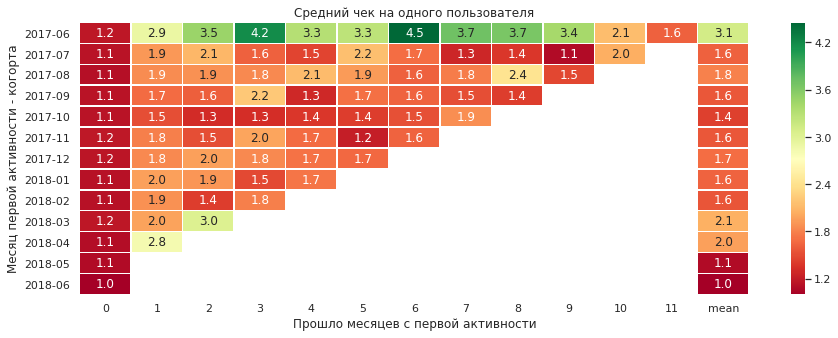

In [102]:
plt.figure(figsize=(15, 5))
plt.title('Средний чек на одного пользователя')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt=".1f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Прошло месяцев с первой активности')
plt.ylabel('Месяц первой активности - когорта')

print('Средний чек всех пользователей равен {:.2f} $'.format(orders['revenue'].mean()))

Первая когорта, как обычно в лидерах. Средни чек у всех остальных примерно одинаковый - 1,5-2 у.е.

#### 2.2.4. Выясним, как меняется во времени накопительный LTV по когортам. Сравним средний LTV по когортам за 6 месяцев. (Оценим когорты, «прожившие» не менее 6 месяцев).

Маржинальность сервиса — 100%.

In [103]:
#Посчитаем количество новых покупателей (n_buyers) за каждый месяц:
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head() 

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [104]:
#Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку:
cohorts = orders.groupby(['first_order_month','month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head() 

,first_order_month,month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [105]:
#Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head()

,first_order_month,n_buyers,month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [106]:
#Найдем валовую прибыль, умножив выручку на маржинальность.
#Во-вторых, сделаем «возрастные» когорты, где в столбцах — не месяц заказа, а возраст (age) когорты.
margin_rate = 1
    
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_order_month,n_buyers,month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4


In [107]:
#найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте.
#Для наглядности визуализируем когорты в виде сводной таблицы:
report['ltv'] = report['gp'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='sum').cumsum(axis=1)

output['mean'] = output.mean(axis=1)    
output.fillna('') 

age,0,1,2,3,4,5,6,7,8,9,10,11,mean
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,5.20974,5.64738,6.60205,7.62458,8.36008,9.31052,9.89212,10.4453,11.0511,11.6224,11.8792,8.530746
2017-07-01,6.010218,6.34543,6.96896,7.32794,7.50473,7.66077,7.78098,7.9228,8.08404,8.23118,8.38685,,7.474900
2017-08-01,5.276518,5.74851,6.20699,6.59827,7.09232,7.37586,7.58653,7.99153,8.28374,8.47172,,,7.063200
2017-09-01,5.644529,6.76212,7.28305,11.2588,11.6594,12.3065,13.0081,13.2512,13.4352,,,,10.512100
2017-10-01,5.003733,5.5395,5.73089,5.88803,6.03959,6.15996,6.24477,6.36024,,,,,5.870840
2017-11-01,5.154683,5.55392,5.75347,6.07842,6.22644,6.28032,6.39524,,,,,,5.920356
2017-12-01,4.738191,4.99856,5.92366,6.98894,7.30187,7.63991,,,,,,,6.265189
2018-01-01,4.135636,4.43039,4.73468,4.87745,4.94015,,,,,,,,4.623662
2018-02-01,4.156987,4.43526,4.51378,4.58792,,,,,,,,,4.423487


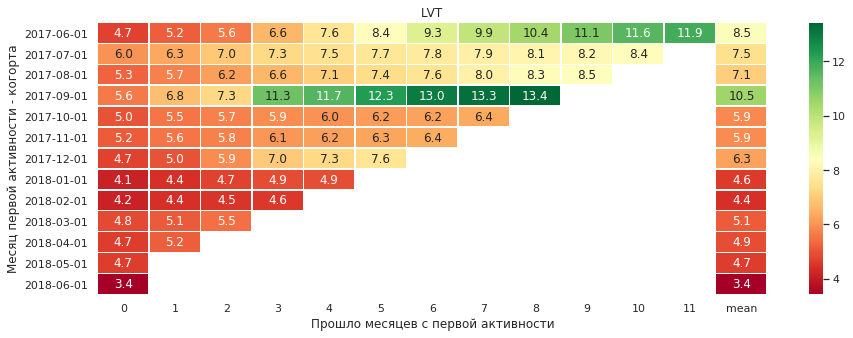

In [108]:
output.index = output.index.strftime('%Y-%m-%d')
plt.figure(figsize=(15, 5))
plt.title('LVT')
sns.heatmap(output, annot=True, fmt=".1f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Прошло месяцев с первой активности')
plt.ylabel('Месяц первой активности - когорта')
plt.show()

Когорты "прожившие" 6 и более месяцев отличаются от остальных когорт по LVT. Каждый из пользователей первых 7 когорт приносит больше денег чем каждый пользователь остальных когорт.

### 2.3. Маркетинговые метрики
#### 2.3.1. Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам и как меняется это распределение во времени

Сколько денег потратили? Всего / на каждый источник / по времени

In [109]:
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [110]:
print('Всего на маркетинг потратили {} у.е.'.format(costs['costs'].sum()))

Всего на маркетинг потратили 329131.62 у.е.


Сумма затрат на маркетинг по источникам

In [111]:
costs_source_sum = costs.groupby('source_id').agg({'costs':'sum'})
costs_source_sum

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


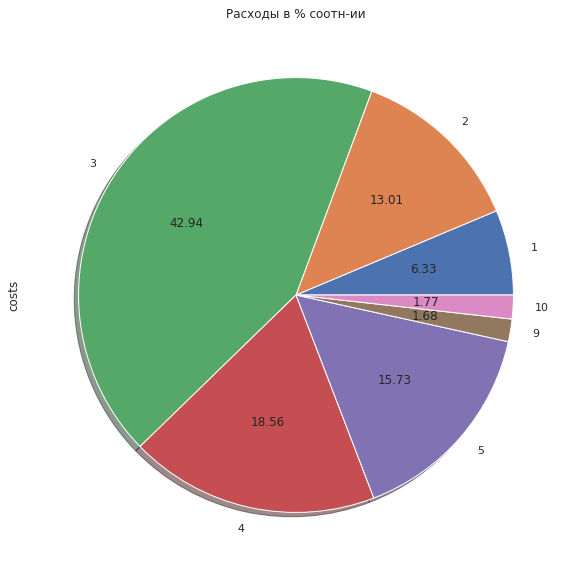

In [112]:

costs_source_sum.plot(kind = 'pie', y = 'costs', autopct='%.2f', figsize = (15, 10), legend = False, shadow=True)

plt.title('Расходы в % соотн-ии')
plt.show()

In [113]:
costs['month'] = costs['dt'].astype('datetime64[M]')

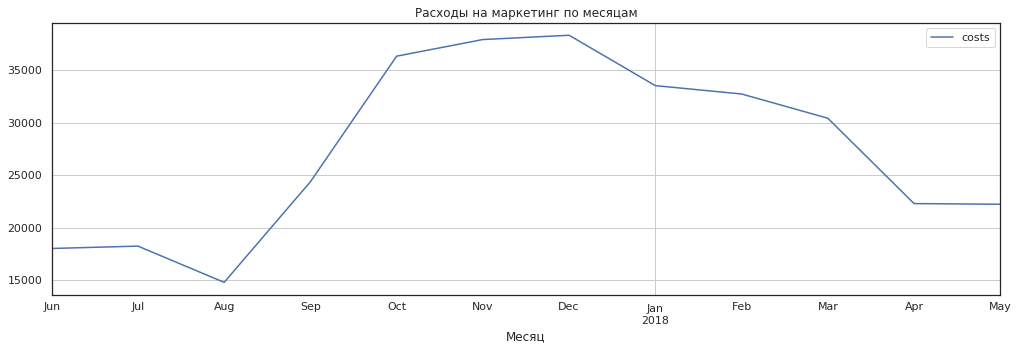

In [114]:
(costs.pivot_table(index = 'month', values = 'costs', aggfunc = 'sum')
      .plot(title = 'Расходы на маркетинг по месяцам', figsize = (17,5), grid=True)
)
plt.xlabel('Месяц')
plt.show()

In [115]:
costs_pivot = costs.pivot_table(index='month',
                                columns='source_id',
                                values='costs',
                                aggfunc='sum')#.cumsum(axis=1))
costs_pivot['sum'] = costs_pivot.sum(axis=1)
costs_pivot

source_id,1,2,3,4,5,9,10,sum
month,,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22,18015.00
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82,18240.59
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57,14790.54
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67,24368.91
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24,36322.88
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36,37907.88
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86,38315.35
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35,33518.52
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88,32723.03


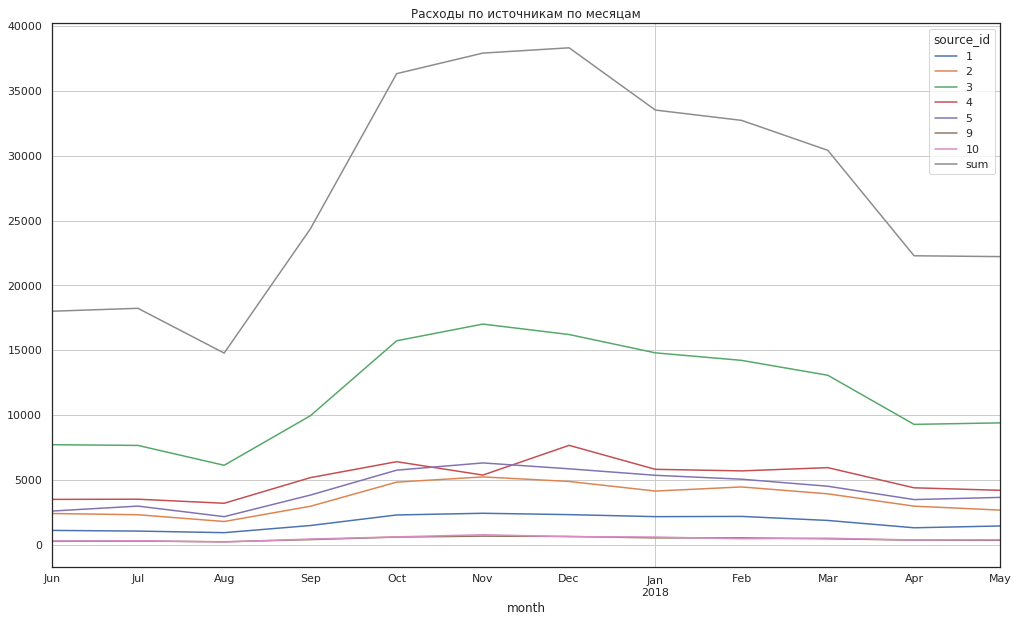

In [116]:
costs_pivot.plot(figsize = (17,10), title = 'Расходы по источникам по месяцам',grid=True)
plt.show()

Самые большие расходы на маркетинг с октября по декабрь. Чуть меньше половины всех расходов (42,94%) занимает 3ий источник. Затем идет 4ый - 18,56% всего бюджета, за ним 5ый - 15,73%. Остальные источники получают меньше 23% бюджетных денег. При чем 6,7 и 8 источники вообще не финансируются. 

В ноябре у 4ого источника был провал в финансировании.

#### 2.3.2. Рассчитаем CAC. Определим, сколько стоит привлечение одного покупателя из каждого источника трафика

<!-- Рекомендации из СЛАКа -->

1. Загружаем 3 таблички: orders, visits, costs
2. Из таблички orders создаем табличку first_orders (из названия должно быть понятно что это за таблицы)
3. Из таблички visits создаем табличку first_visits  (из названия должно быть понятно что это за таблицы)
4. Делаем левый мердж first_orders и first_visits по uid. Теперь у нас есть таблица buyers, в которой для каждого пользователя есть source_id, что мы и хотели.
5. Группируем таблицу buyers по source_id и first_order_dt (дате первой покупки) и применяем count чтобы посчитать кол-во покупателей в каждой такой группе. Назовем полученную колонку n_buyers.
6. Делаем merge полученной таблицы с таблицей costs по source_id, first_order_dt. В итоге в этой таблице у нас есть и n_buyers и costs, а значит мы можем посчитать costs_per_buyer
7. Группируем таблицу их пункта 6 по source_id и усредняем значения столбца costs_per_buyer в каждой группе
8. Всё, мы посчитали CAC для каждого source_id:) Это не таблица, как было в случае с LTV. Это просто один столбец, где для каждого source_id записано одно число.

In [117]:
first_orders

,first_buy_ts,first_activity,first_source_id,first_device,time_to_first_purchase
uid,,,,,
313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,2,desktop,154022.0
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,10,touch,0.0
2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,3,desktop,79.0
2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,5,desktop,1184.0
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,5,desktop,0.0
...,...,...,...,...,...
18445147675727495770,2017-11-24 09:03:00,2017-08-20 13:30:00,5,touch,137973.0
18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00,3,desktop,7.0
18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00,2,desktop,333303.0


In [118]:
#Переименуем некоторые стобцы в  first_orders
first_orders = first_orders.reset_index()
first_orders = first_orders.rename(columns={'first_source_id':'source_id', 'first_device':'device'})

In [119]:
first_orders['first_buy_ts'] = first_orders['first_buy_ts'].astype('datetime64[M]')

In [120]:
first_orders['first_activity'] = first_orders['first_activity'].astype('datetime64[M]')

In [121]:
#Оставим в buyers только нужные для анализа столбцы first_orders
buyers = first_orders[['uid', 'first_buy_ts', 'first_activity', 'source_id', 'device']]
buyers

,uid,first_buy_ts,first_activity,source_id,device
0,313578113262317,2018-01-01,2017-09-01,2,desktop
1,1575281904278712,2017-06-01,2017-06-01,10,touch
2,2429014661409475,2017-10-01,2017-10-01,3,desktop
3,2464366381792757,2018-01-01,2018-01-01,5,desktop
4,2551852515556206,2017-11-01,2017-11-01,5,desktop
...,...,...,...,...,...
36518,18445147675727495770,2017-11-01,2017-08-01,5,touch
36519,18445407535914413204,2017-09-01,2017-09-01,3,desktop
36520,18445601152732270159,2018-03-01,2017-08-01,2,desktop
36521,18446156210226471712,2018-02-01,2017-11-01,3,desktop


In [122]:
#Группируем таблицу buyers по source_id и first_order_dt (дате первой покупки) 
#и применяем count чтобы посчитать кол-во покупателей в каждой такой группе. Назовем полученную колонку n_buyers.
n_buyers = buyers.groupby(['source_id', 'first_buy_ts']).agg({'uid':'count'}).reset_index()
n_buyers = n_buyers.rename(columns={'first_buy_ts':'month', 'uid':'count_uid'})
n_buyers

,source_id,month,count_uid
0,1,2017-06-01,203
1,1,2017-07-01,211
2,1,2017-08-01,145
3,1,2017-09-01,283
4,1,2017-10-01,409
...,...,...,...
81,10,2018-01-01,87
82,10,2018-02-01,126
83,10,2018-03-01,178
84,10,2018-04-01,112


In [123]:
#Сумма затрат на марекетинг по месяцам
costs_grouped_sum = costs.groupby(['source_id', 'month']).agg({'costs':'sum'})
costs_grouped_sum

costs
source_id month              
1         2017-06-01  1125.61
          2017-07-01  1072.88
          2017-08-01   951.81
          2017-09-01  1502.01
          2017-10-01  2315.75
...                       ...
10        2018-01-01   614.35
          2018-02-01   480.88
          2018-03-01   526.41
          2018-04-01   388.25
          2018-05-01   409.86

[84 rows x 1 columns]

In [124]:
#Соединим n_buyers с таблицей costs по source_id, first_order_dt.
#В итоге в этой таблице у нас есть и n_buyers и costs, а значит мы можем посчитать затраты на каждого клиента (costs_per_buyer)
n_buyers = pd.merge(n_buyers, costs_grouped_sum, on=('source_id', 'month'))
n_buyers['costs_per_buyer'] = n_buyers['costs'] / n_buyers['count_uid']
n_buyers

,source_id,month,count_uid,costs,costs_per_buyer
0,1,2017-06-01,203,1125.61,5.544877
1,1,2017-07-01,211,1072.88,5.084739
2,1,2017-08-01,145,951.81,6.564207
3,1,2017-09-01,283,1502.01,5.307456
4,1,2017-10-01,409,2315.75,5.661980
...,...,...,...,...,...
79,10,2018-01-01,87,614.35,7.061494
80,10,2018-02-01,126,480.88,3.816508
81,10,2018-03-01,178,526.41,2.957360
82,10,2018-04-01,112,388.25,3.466518


In [125]:
#Группируем таблицу n_buyers по source_id и усредняем значения столбца costs_per_buyer в каждой группе
#Всё, мы посчитали CAC для каждого source_id:) Это не таблица, как было в случае с LTV. 
#Это просто один столбец, где для каждого source_id записано одно число.
costs_grouped = n_buyers.groupby('source_id').agg({'costs_per_buyer':'mean', 'costs':'sum', 'count_uid':'sum'})
costs_grouped

,costs_per_buyer,costs,count_uid
source_id,,,
1,5.600034,20833.27,3743
2,10.087368,42806.04,4323
3,15.884857,141321.63,9138
4,6.687370,61073.60,9822
5,7.553257,51757.10,6839
9,4.301936,5517.49,1415
10,5.259864,5822.49,1241


In [126]:
#Посмотрим сводную таблицу по средним затратам на маркетинг на каждого покупателя (по месяцам и источникам перехода)
cac_per_month = n_buyers.pivot_table(index='month',columns='source_id',values='costs_per_buyer',aggfunc='mean')
cac_per_month

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,5.544877,8.957122,13.469774,8.428777,7.109022,2.769126,3.611724
2017-07-01,5.084739,9.078249,17.323634,7.233053,7.439553,4.033867,7.170000
2017-08-01,6.564207,11.836928,21.184621,9.779210,6.602054,2.963452,6.285676
2017-09-01,5.307456,9.600193,15.399614,8.906106,6.579726,3.996346,6.774559
2017-10-01,5.661980,9.728916,15.219768,5.805461,6.214871,3.502356,3.283979
2017-11-01,5.409646,10.169922,16.545520,4.790062,9.627610,3.614709,7.012035
2017-12-01,5.111790,9.584736,14.202732,5.958472,7.946576,3.987758,8.175443
2018-01-01,6.487181,12.121691,17.483802,5.832790,8.302195,4.885357,7.061494
2018-02-01,6.389797,11.805646,14.638436,5.486993,7.546592,4.754310,3.816508


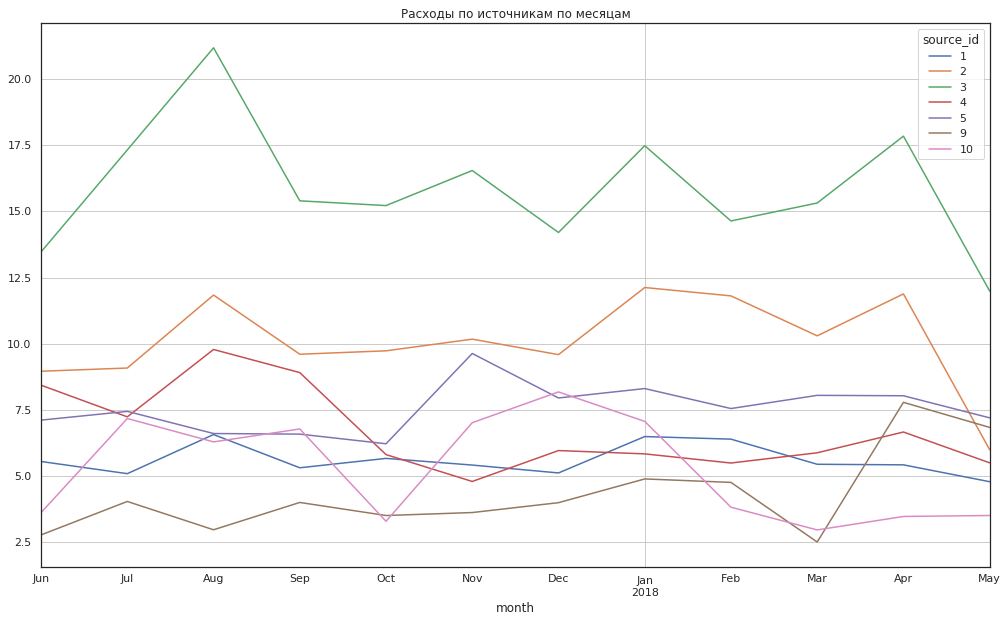

In [127]:
(cac_per_month.plot(figsize = (17,10), title = 'Расходы по источникам по месяцам',grid=True)
)
plt.show()

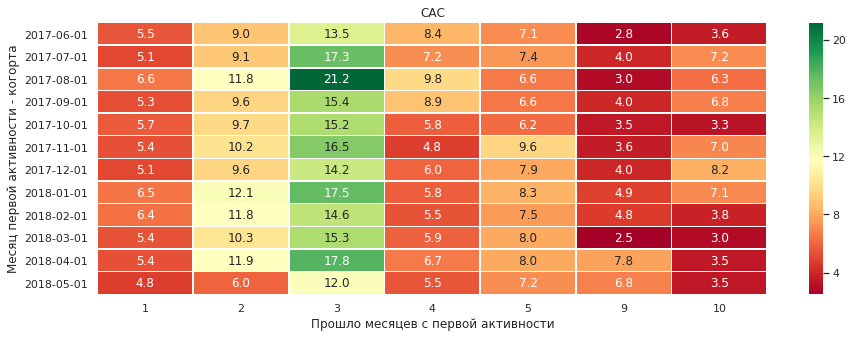

In [128]:
cac_per_month.index = cac_per_month.index.strftime('%Y-%m-%d')
plt.figure(figsize=(15, 5))
plt.title('CAC')
sns.heatmap(cac_per_month,
            annot=True, fmt=".1f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Прошло месяцев с первой активности')
plt.ylabel('Месяц первой активности - когорта')
plt.show()

Максимальные расходы на маркетинг у 3его канала (в среднем 15,88 у.е на покупателя). Второе место занимает 2ой канал (в среднем 10,09 у.е на покупателя)

## 2.3.3. Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт.

На сколько окупились расходы? (ROI)

In [129]:
orders.groupby('uid').agg({'revenue':'sum'})

,revenue
uid,
313578113262317,0.55
1575281904278712,3.05
2429014661409475,73.33
2464366381792757,2.44
2551852515556206,10.99
...,...
18445147675727495770,3.05
18445407535914413204,0.88
18445601152732270159,4.22


In [130]:
order_visits = orders.join(visits.sort_values('start_ts').groupby('uid').agg({'source_id':'first', 'device':'first',
                                                                             'start_ts':'min'}), on='uid', how='inner')
order_visits

,buy_ts,revenue,uid,first_buy_ts,first_activity,first_source_id,first_device,time_to_first_purchase,first_order_month,month,source_id,device,start_ts
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,1,desktop,1.0,2017-06-01,2017-06-01,1,desktop,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,2,desktop,11.0,2017-06-01,2017-06-01,2,desktop,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,2,desktop,2.0,2017-06-01,2017-06-01,2,desktop,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,2,desktop,15.0,2017-06-01,2017-06-01,2,desktop,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,3,desktop,27.0,2017-06-01,2017-06-01,3,desktop,2017-06-01 07:31:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-31 09:11:00,4,desktop,879.0,2018-05-01,2018-05-01,4,touch,2018-05-31 09:11:00
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-31 23:05:00,10,desktop,45.0,2018-05-01,2018-05-01,10,desktop,2018-05-31 23:05:00
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-31 23:52:00,3,desktop,2.0,2018-05-01,2018-05-01,3,desktop,2018-05-31 23:52:00
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2017-10-23 12:32:00,4,desktop,317484.0,2018-05-01,2018-05-01,3,desktop,2017-10-23 12:32:00


In [131]:
#Сгруппируем таблицу по источникам тафика и подсчитаем выручку по каждому
ord_vis_grouped = order_visits.groupby(['source_id', 'month']).agg({'revenue':'sum', 'uid': 'count'})
ord_vis_grouped['revenue_per_uid'] = ord_vis_grouped['revenue'] / ord_vis_grouped['uid']
ord_vis_grouped.reset_index()

,source_id,month,revenue,uid,revenue_per_uid
0,1,2017-06-01,1378.70,268,5.144403
1,1,2017-07-01,1581.68,261,6.060077
2,1,2017-08-01,1441.49,243,5.932058
3,1,2017-09-01,3071.61,449,6.841002
4,1,2017-10-01,3621.82,587,6.170051
...,...,...,...,...,...
81,10,2018-01-01,304.53,102,2.985588
82,10,2018-02-01,338.30,149,2.270470
83,10,2018-03-01,679.51,234,2.903889
84,10,2018-04-01,286.50,123,2.329268


Подсчет ROMI по источникам

In [132]:
romi = pd.merge(n_buyers, ord_vis_grouped, on=(['source_id', 'month']))
romi

,source_id,month,count_uid,costs,costs_per_buyer,revenue,uid,revenue_per_uid
0,1,2017-06-01,203,1125.61,5.544877,1378.70,268,5.144403
1,1,2017-07-01,211,1072.88,5.084739,1581.68,261,6.060077
2,1,2017-08-01,145,951.81,6.564207,1441.49,243,5.932058
3,1,2017-09-01,283,1502.01,5.307456,3071.61,449,6.841002
4,1,2017-10-01,409,2315.75,5.661980,3621.82,587,6.170051
...,...,...,...,...,...,...,...,...
79,10,2018-01-01,87,614.35,7.061494,304.53,102,2.985588
80,10,2018-02-01,126,480.88,3.816508,338.30,149,2.270470
81,10,2018-03-01,178,526.41,2.957360,679.51,234,2.903889
82,10,2018-04-01,112,388.25,3.466518,286.50,123,2.329268


In [133]:
romi['romi'] = romi['revenue_per_uid'] / romi['costs_per_buyer']
romi['romi_all'] = romi['revenue'] / romi['costs']
romi

,source_id,month,count_uid,costs,costs_per_buyer,revenue,uid,revenue_per_uid,romi,romi_all
0,1,2017-06-01,203,1125.61,5.544877,1378.70,268,5.144403,0.927776,1.224847
1,1,2017-07-01,211,1072.88,5.084739,1581.68,261,6.060077,1.191817,1.474238
2,1,2017-08-01,145,951.81,6.564207,1441.49,243,5.932058,0.903698,1.514472
3,1,2017-09-01,283,1502.01,5.307456,3071.61,449,6.841002,1.288942,2.045000
4,1,2017-10-01,409,2315.75,5.661980,3621.82,587,6.170051,1.089734,1.563994
...,...,...,...,...,...,...,...,...,...,...
79,10,2018-01-01,87,614.35,7.061494,304.53,102,2.985588,0.422798,0.495695
80,10,2018-02-01,126,480.88,3.816508,338.30,149,2.270470,0.594908,0.703502
81,10,2018-03-01,178,526.41,2.957360,679.51,234,2.903889,0.981919,1.290838
82,10,2018-04-01,112,388.25,3.466518,286.50,123,2.329268,0.671933,0.737927


In [134]:
romi_pivot = romi.pivot_table(index='month',columns='source_id',values='romi')
romi_pivot

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,0.927776,0.414660,0.295732,0.497897,0.597561,1.109384,0.587977
2017-07-01,1.191817,0.737874,0.319915,0.681414,0.645335,0.904915,0.451089
2017-08-01,0.903698,0.436027,0.229024,0.470562,0.707652,1.137992,0.723635
2017-09-01,1.288942,0.727697,0.329555,0.508996,0.890669,0.852390,0.298692
2017-10-01,1.089734,0.842055,0.285221,0.730389,0.746241,1.216504,0.751716
2017-11-01,1.141392,0.661228,0.250548,0.987750,0.441848,0.846692,0.552590
2017-12-01,0.864394,0.681246,0.255042,0.713626,1.551071,0.936790,0.425066
2018-01-01,0.845120,0.431853,0.213907,0.594317,0.538604,0.589070,0.422798
2018-02-01,0.749378,0.800190,0.240526,0.726968,0.692910,0.881809,0.594908


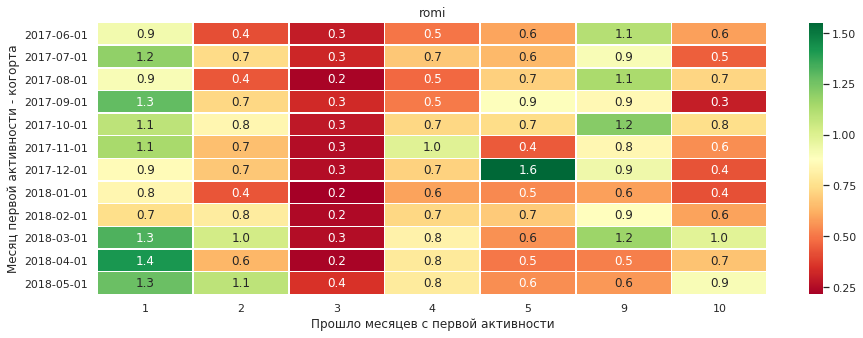

In [135]:
romi_pivot.index = romi_pivot.index.strftime('%Y-%m-%d')
plt.figure(figsize=(15, 5))
plt.title('romi')
sns.heatmap(romi_pivot, annot=True, fmt=".1f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Прошло месяцев с первой активности')
plt.ylabel('Месяц первой активности - когорта')
plt.show()

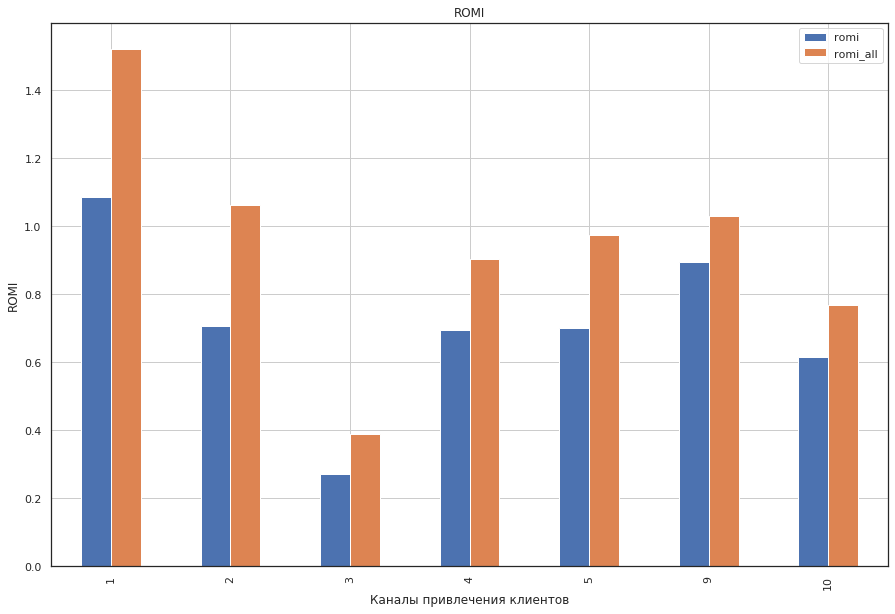

In [136]:
romi.groupby('source_id').agg({'romi':'mean', 'romi_all': 'mean'}).plot.bar(grid=True, title='ROMI', figsize=(15,10))
plt.ylabel('ROMI')
plt.xlabel('Каналы привлечения клиентов')
plt.show()

По окупаемости лидирует 1ый канал. Зан им идет 9ый, Третье место делят2ой, 4ый и 5ый каналы

## Шаг 3. Сформулируйте выводы и рекомендации

### 3.1. Определите источники трафика и тип устройств, на которые маркетологам стоит делать упор. Объясните свой выбор: на какие метрики вы ориентируетесь и почему

"Делать упор" следует на 1ый и 9ый каналы привлечения клиентов. Потому что окупаемость по эти м канала высокая. Необходимо перераспределить вложения в рекламные каналы и сместить акцент с 3 канала, который особо убыточен для компании.

Исходя из продуковых метрик, пользователи, которые заходили на сервис используя компьютер, делали это чаще. Думаю на них нужно обратить особое внимание. Возможно мобильное приложение плохо работает или не удобно для использования, в отличии от основного сайта сервиса.

### 3.2. Опишите выводы, которые вы сделали после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции

**Маркетинг**
Самые большие расходы на маркетинг с октября по декабрь 2017 года:
Октябрь - 36322.88 у.е.
Ноябрь – 37907.88 у.е.
Декабрь – 38315.35 у.е.
Чуть меньше половины всех расходов (42,94%) занимает 3ий источник. Затем идет 4ый - 18,56% всего бюджета, за ним 5ый - 15,73%. Остальные источники получают меньше 23% бюджетных денег. При чем 6,7 и 8 источники вообще не финансируются. 
Максимальные расходы на маркетинг у 3его канала - в среднем 15,88 у.е на покупателя  (141321.63 у.е за весь период). Второе место занимает 2ой канал - в среднем 10,09 у.е на покупателя (42806.04 у.е за весь период). У 4ого и 5ого каналов финансирование за весь период больше чем у второго (4ый - 61073.60 у.е., 5ый - 51757.10 у.е.), но из-за большего числа покупателей, расходы на каждого меньше чем у 2ого канала (4ый -6,69 у.е. на чел., 5ый – 7,55 у.е. на чел.)

**Продукт**
В среднем, на сервис, с компьютера заходят в 2.5 раза больше людей, чем с телефона. А так же, с компьютера, заходят чаще в будние дни, чем в выходные. Пиковое значение посетителей сервиса было – 24/11/2017 – 3319 пользователей. Видимо была рекламная акция. А так же 31/03/2018 сервис посетил 1 человек. Скорее всего был сбой. 
На последней неделе декабря 2017 года так же был провал в посещаемости сервиса (3200-4100  пользователей в неделю)
Средняя продолжительность одной сессии – 60 сек. Возможно есть какие-то трудности с регистрацией или просмотром сервиса.
Необходимо отметить, что Retention довольно низкий . Retention второго месяца пользования сервисом находится в интервале от 4 до 8,5% в зависимости от когорты.

**Электронная коммерция**
У большей части пользователей на оформление заказа уходит не более 3-5 минут. Т.е. они заходят на сервис и сразу делают заказ. Видно, что заходят они сразу по делу, а не посидеть поискать что-либо интересное.
За 6 месяцев пользования сервисом каждый пользователь совершил от 89 до 11 покупок. Из всех когорт выделяется первая – 18 покупок на пользователя за 6 мес.
По среднему чеку первая когорта, как обычно в лидерах – 3,1 у.е.. Средни чек у всех остальных примерно одинаковый - 1,5-2 у.е.
Когорты "прожившие" 6 и более месяцев отличаются от остальных когорт по LVT. Каждый из пользователей первых 7 когорт приносит больше денег чем каждый пользователь остальных когорт. По среднему чеку лидирует 4ая когорта – 10,5 у.е, второе место у 1ой – 8,5 у.е., третье и четвертое место получили 2ая и 3я когорты, соответственно (2ая – 7,5 у.е., 3я – 7,1 у.е.)


### 3.3. Подведите итоги когортного анализа. Определите самые перспективные для компании когорты клиентов

Самые перспективные когорты – 1ая и 4ая исходя из LVT:
* Средний LVT 1ой когорты – 8,5
* Средний LVT 1ой когорты – 10,5

Но средний чек у 4ой когорты (1,6) ниже чем у 1ой(3,1). 

Думаю следует присмотреться к 10ой и 11ой когортам, потому что на начальном этапе LVT и средний чек схожи с лидерами.


### 3.4. Опишите, как различаются метрики в разрезе устройств.

Графики продуктовых метрик в разрезе устройств схожи. Пики и падения в одно и тоже время. Отличаются только количеством пользователей. Можно сказать, что рекламные акции и сбои в работе сервиса одинаково отражаются на пользователях, заходивших на сервис с разных устройств.